In [1]:
# Block 1
# Load the Cifar-10 Dataset

import time
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Start the timer
start_time = time.time()

# Set up transformations for CIFAR-10 images
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to 224x224 for ResNet-18
    transforms.ToTensor(),                  # Convert images to tensors
    transforms.Normalize(                   # Normalize as per ResNet-18
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)


end_time = time.time()

print(f"Runtime: {end_time - start_time:.2f} seconds") # 23 sec t4

100%|██████████| 170M/170M [00:18<00:00, 9.02MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Runtime: 23.74 seconds


<h1 style="text-align: left; font-size: 70px;">2 - Dataset Overview</h1>

In [2]:
# Block 2
# Question 2 - Dataset Overview
# Bullet Point 1

start_time = time.time()

# Select 500 images per class for training and 100 per class for testing
def subset_per_class(dataset, num_per_class):
    class_indices = [[] for _ in range(10)]  # CIFAR-10 has 10 classes

    # Sort each index by class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # Pick the specified number per class
    selected_indices = [idx for indices in class_indices for idx in indices[:num_per_class]]
    return Subset(dataset, selected_indices)

# 500 training images per class, 100 test images per class
trainset_reduced = subset_per_class(trainset, 500)
testset_reduced = subset_per_class(testset, 100)

# Loaders for batch processing
train_loader = DataLoader(trainset_reduced, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(testset_reduced, batch_size=32, shuffle=False, num_workers=2)

# Check dataset structure
print(f"Training set size: {len(trainset_reduced)} images")
print(f"Test set size: {len(testset_reduced)} images")



end_time = time.time()

print(f"Runtime: {end_time - start_time:.2f} seconds") # 77 seconds on t4 GPU | 61 secs A100

Training set size: 5000 images
Test set size: 1000 images
Runtime: 65.78 seconds


In [3]:
# Block 3
# Question 2 - Dataset Overview (ResNet18-CNN conversion for Naive Bayes)
## Bulet Point 2

import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from torchvision.models import ResNet18_Weights

start_time = time.time()

# Loading Pre-trained Res-Net-18
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # Loads ResNet18 with pretrained weights (source: Deep Learning Assignemnt)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1]) # remove final classifciaton layer
resnet18.eval()

# Use Gpu since its faster than CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device) # --> GPU

# Freezing Layers (Optional, not sure if we should do this but its good practice VERIFY RAHATH)
#
for param in resnet18.parameters():
    param.requires_grad = False  # Freeze all layers

def extract_features(loader,  model):
    features = []
    labels = []

    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            outputs = model(images).squeeze()
            features.extend(outputs.cpu().numpy())
            labels.extend(label.numpy())

    return np.array(features), np.array(labels)


# Extract these features for our training and test datasets

training_features, training_labels = extract_features(train_loader, resnet18)
test_features, test_labels = extract_features(test_loader, resnet18)


# Save extracted features in case we need to use it for bullet point 3
np.save('training_features.npy', training_features)
np.save('training_labels.npy', training_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

# Shape of training and test features
print(f"Training features shape: {training_features.shape}")
print(f"Test features shape: {test_features.shape}")

end_time = time.time()

print(f"Runtime: {end_time - start_time:.2f} seconds") # 8.27 seconds t4 | 7.52 seconds A100

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


Training features shape: (5000, 512)
Test features shape: (1000, 512)
Runtime: 8.83 seconds


In [4]:
# Block 4
# Question 2 Reduced the size of the vectors to ≈512x1 and 50x1 using from sklearn.decomposition import PCA
## Bullet Point 3

from sklearn.decomposition import PCA

start_time = time.time()

# load the extracted featured saved vectors
training_features = np.load('training_features.npy')
training_labels = np.load('training_labels.npy')
test_features = np.load('test_features.npy')
test_labels = np.load('test_labels.npy')

# Use PCA to reduced the vectors size to 50
pcs = PCA(n_components=50)
training_features_PCA = pcs.fit_transform(training_features)
test_features_PCA = pcs.transform(test_features)


# Save the new vectors for Naives Bayes Section
np.save('training_features_reduced_PCA.npy', training_features)
np.save('test_features_reduced_PCA.npy', test_features)

# Verify that its proper dimensions
print(f"Training features shape: {training_features_PCA.shape}")
print(f"Test features shape: {test_features_PCA.shape}")


# Timer (For debugging and clarity)
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")



Training features shape: (5000, 50)
Test features shape: (1000, 50)
Runtime: 1.28 seconds


<h1 style="text-align: left; font-size: 70px;">3 - Naive Bayes</h1>

In [ ]:
# Block 5
# 3: Naives Bayes
## Bullet Point 1

import numpy as np
from sklearn.metrics import accuracy_score
import pickle #to save the mdoel

# Would've used the libary since its a lot easier but not allowed

start_time = time.time()

# Load PCA and labels for trainign and test from previous section
training_features_PCA = np.load('training_features_reduced_PCA.npy')
training_labels = np.load('training_labels.npy')
test_features_PCA = np.load('test_features_reduced_PCA.npy')
test_labels = np.load('test_labels.npy')


# Implement Gaussian Naive Bayes algorithm

class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]

        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)

        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[i, :] = X_c.mean(axis=0)
            self.var[i, :] = X_c.var(axis=0)
            self.priors[i] = X_c.shape[0] / X.shape[0]

    def gaussian_pdf(self, x, mean, var):
        non_zero = 1e-10  # Prevent division by zero
        var += non_zero
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        pdf = (1 / np.sqrt(2 * np.pi * var)) * exponent
        return np.maximum(pdf, 1e-10)  # Set a minimum threshold for PDF values

    def predict(self, X):
        y_pred = np.array([self.predict_single_value(x) for x in X])
        return y_pred

    def predict_single_value(self, x):
        posteriors = []

        for i, c in enumerate(self.classes):
            prior = np.log(self.priors[i])
            likelihoods = np.log(np.maximum(self.gaussian_pdf(x, self.mean[i], self.var[i]), 1e-10))
            posterior = prior + np.sum(likelihoods)
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]



# Call the model and train it
gnb = GaussianNaiveBayes()
gnb.fit(training_features_PCA, training_labels)

# Predict the test set
y_pred = gnb.predict(test_features_PCA)

# Accuracy
print("Accuracy:", accuracy_score(test_labels, y_pred))

# Save the trained model using Pickle
naive_bayes_model_path = "naive_bayes_manual_bp1.pkl"
with open(naive_bayes_model_path, "wb") as model_file:
    pickle.dump(gnb, model_file)
print(f"Trained Naive Bayes model saved at {naive_bayes_model_path}")

# Timer
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")

Accuracy: 0.803
Trained Naive Bayes model saved at naive_bayes_manual_bp1.pkl
Runtime: 0.43 seconds


In [ ]:
# Block 6
# 3: Naives Bayes
## Bullet Point 2

# We will use Scikit-Learn's built-in Gaussian Naive Bayes classifier for this block since we are now allwoed to do so
# Shoudl be same output as the manually implemented Gaussian Naive Bayes classfier

from sklearn.naive_bayes import GaussianNB

start_time = time.time()

# Load PCA and labels for trainign and test from Bayes Section
training_features_PCA = np.load('training_features_reduced_PCA.npy')
training_labels = np.load('training_labels.npy')
test_features_PCA = np.load('test_features_reduced_PCA.npy')
test_labels = np.load('test_labels.npy')


# Call the Scikit-Learn's built-in Gaussian Naive Bayes classifier method and train it
gnb_sklearn = GaussianNB()
gnb_sklearn.fit(training_features_PCA, training_labels)

# Predict the test set
y_prediction_skLearn = gnb_sklearn.predict(test_features_PCA)

# Accuracy
print("Accuracy:", accuracy_score(test_labels, y_prediction_skLearn))


# Save the skLearn version of Naive Bayes mdoel
naive_bayes_sklearn_model_path = "naive_bayes_scikit_bp2.pkl"
with open(naive_bayes_sklearn_model_path, "wb") as model_file:
    pickle.dump(gnb_sklearn, model_file)
print(f"Trained Scikit-Learn Naive Bayes model saved at {naive_bayes_sklearn_model_path}")


# Timer
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")




Accuracy: 0.802
Trained Scikit-Learn Naive Bayes model saved at naive_bayes_scikit_bp2.pkl
Runtime: 0.04 seconds


Evaluating BP1 (Manual Implementation)...


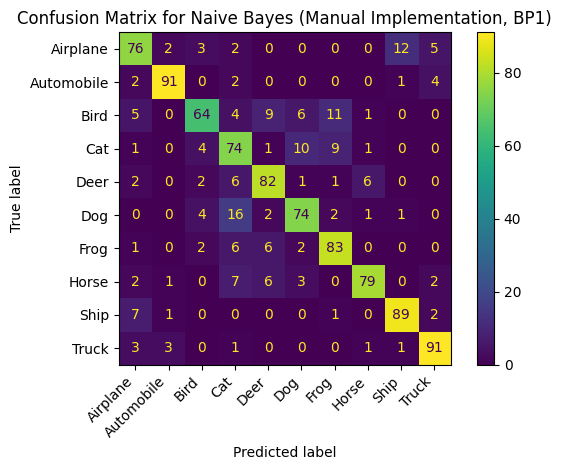


Classification Report for Naive Bayes (Manual Implementation, BP1):
              precision    recall  f1-score   support

    Airplane       0.77      0.76      0.76       100
  Automobile       0.93      0.91      0.92       100
        Bird       0.81      0.64      0.72       100
         Cat       0.63      0.74      0.68       100
        Deer       0.77      0.82      0.80       100
         Dog       0.77      0.74      0.76       100
        Frog       0.78      0.83      0.80       100
       Horse       0.89      0.79      0.84       100
        Ship       0.86      0.89      0.87       100
       Truck       0.88      0.91      0.89       100

    accuracy                           0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000

Accuracy for BP1 (Manual Implementation): 80.30%

Evaluating BP2 (Scikit-Learn Implementation)...


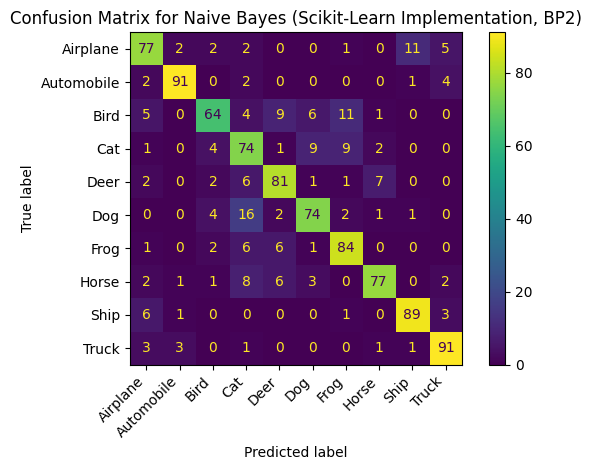


Classification Report for Naive Bayes (Scikit-Learn Implementation, BP2):
              precision    recall  f1-score   support

    Airplane       0.78      0.77      0.77       100
  Automobile       0.93      0.91      0.92       100
        Bird       0.81      0.64      0.72       100
         Cat       0.62      0.74      0.68       100
        Deer       0.77      0.81      0.79       100
         Dog       0.79      0.74      0.76       100
        Frog       0.77      0.84      0.80       100
       Horse       0.87      0.77      0.81       100
        Ship       0.86      0.89      0.88       100
       Truck       0.87      0.91      0.89       100

    accuracy                           0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000

Accuracy for BP2 (Scikit-Learn Implementation): 80.20%

Summary of Naive Bayes Model Evaluations:
Accuracy of BP1 (Manual Implementation): 80.30%
Accuracy of BP2 (Sci

In [6]:
# Block 7
# 3: Naives Bayes
## Bullet Point 3

# Evaluation and Plotting of the Naives Bayes model
## This incldues: Confusion Matrix, Classification Report

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import time

start_time = time.time()

# Class definition for GaussianNaiveBayes (used in BP1)
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]

        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)

        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[i, :] = X_c.mean(axis=0)
            self.var[i, :] = X_c.var(axis=0)
            self.priors[i] = X_c.shape[0] / X.shape[0]

    def gaussian_pdf(self, x, mean, var):
        non_zero = 1e-10  # Prevent division by zero
        var += non_zero
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        pdf = (1 / np.sqrt(2 * np.pi * var)) * exponent
        return np.maximum(pdf, 1e-10)  # Set a minimum threshold for PDF values

    def predict(self, X):
        y_pred = np.array([self.predict_single_value(x) for x in X])
        return y_pred

    def predict_single_value(self, x):
        posteriors = []

        for i, c in enumerate(self.classes):
            prior = np.log(self.priors[i])
            likelihoods = np.log(np.maximum(self.gaussian_pdf(x, self.mean[i], self.var[i]), 1e-10))
            posterior = prior + np.sum(likelihoods)
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]


# Load PCA features and labels
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")

# Class names for CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Load the manually implemented Naive Bayes model from BP1
with open("naive_bayes_manual_bp1.pkl", "rb") as file:
    gnb_manual = pickle.load(file)

# Load the Scikit-Learn Naive Bayes model from BP2
with open("naive_bayes_scikit_bp2.pkl", "rb") as file:
    gnb_sklearn = pickle.load(file)

# Evaluate BP1 (Manual Implementation)
print("Evaluating BP1 (Manual Implementation)...")
y_pred_bp1 = gnb_manual.predict(test_features_PCA)
accuracy_bp1 = accuracy_score(test_labels, y_pred_bp1)

# Generate Confusion Matrix and Classification Report for BP1
cm_bp1 = confusion_matrix(test_labels, y_pred_bp1)
disp_bp1 = ConfusionMatrixDisplay(confusion_matrix=cm_bp1, display_labels=class_names)
disp_bp1.plot()
plt.title("Confusion Matrix for Naive Bayes (Manual Implementation, BP1)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\nClassification Report for Naive Bayes (Manual Implementation, BP1):")
print(classification_report(test_labels, y_pred_bp1, target_names=class_names))
print(f"Accuracy for BP1 (Manual Implementation): {accuracy_bp1 * 100:.2f}%\n")
print("=" * 80)

# Evaluate BP2 (Scikit-Learn Implementation)
print("Evaluating BP2 (Scikit-Learn Implementation)...")
y_pred_bp2 = gnb_sklearn.predict(test_features_PCA)
accuracy_bp2 = accuracy_score(test_labels, y_pred_bp2)

# Generate Confusion Matrix and Classification Report for BP2
cm_bp2 = confusion_matrix(test_labels, y_pred_bp2)
disp_bp2 = ConfusionMatrixDisplay(confusion_matrix=cm_bp2, display_labels=class_names)
disp_bp2.plot()
plt.title("Confusion Matrix for Naive Bayes (Scikit-Learn Implementation, BP2)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\nClassification Report for Naive Bayes (Scikit-Learn Implementation, BP2):")
print(classification_report(test_labels, y_pred_bp2, target_names=class_names))
print(f"Accuracy for BP2 (Scikit-Learn Implementation): {accuracy_bp2 * 100:.2f}%\n")
print("=" * 80)

# Print final summary
print("Summary of Naive Bayes Model Evaluations:")
print(f"Accuracy of BP1 (Manual Implementation): {accuracy_bp1 * 100:.2f}%")
print(f"Accuracy of BP2 (Scikit-Learn Implementation): {accuracy_bp2 * 100:.2f}%")

# Timer
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")

<h1 style="text-align: left; font-size: 70px;">4 - Decision Tree</h1>



In [ ]:
# Block 8
# 4: Decision Tree
# Bullet Point 1

# Manually construct a decision tree classifer

from collections import Counter
import pickle
import numpy as np
import time

start_time = time.time()

class SelfMadeDecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples_split=2, min_samples_leaf=1):

        # Initialize the Decision Tree Classifier
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def gini_value(self, y):

        # Calculate the Gini impurity for a given set of labels
        counts = Counter(y)  # Count occurrences of each class
        gini = 1 - sum((count / len(y)) ** 2 for count in counts.values())  # Calculate Gini impurity
        return gini

    def split(self, X, y, feature_index, threshold):

        # Split dataset using indices.
        left_indices = X[:, feature_index] < threshold
        right_indices = ~left_indices
        return np.where(left_indices)[0], np.where(right_indices)[0]

    def best_split(self, X, y):

        # Find the best split
        best_feature, best_threshold, best_gini = None, None, float('inf')
        n_samples, n_features = X.shape

        for feature_index in range(n_features):
            # Sort feature values and labels
            sorted_indices = np.argsort(X[:, feature_index])
            X_sorted, y_sorted = X[sorted_indices, feature_index], y[sorted_indices]

            # Pre-compute total counts
            total_counts = Counter(y_sorted)
            left_counts = Counter()
            right_counts = total_counts.copy()

            for i in range(1, n_samples):
                label = y_sorted[i - 1]
                left_counts[label] += 1
                right_counts[label] -= 1

                if X_sorted[i] == X_sorted[i - 1]:
                    continue  # Skip redundant thresholds

                left_size = i
                right_size = n_samples - i

                left_gini = 1 - sum((count / left_size) ** 2 for count in left_counts.values())
                right_gini = 1 - sum((count / right_size) ** 2 for count in right_counts.values())
                gini = (left_size / n_samples) * left_gini + (right_size / n_samples) * right_gini

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_index
                    best_threshold = (X_sorted[i - 1] + X_sorted[i]) / 2

        return best_feature, best_threshold

    def _split_gini(self, X_feature, y, threshold):

        left_indices = X_feature < threshold
        y_left, y_right = y[left_indices], y[~left_indices]  # Split target values

        # Calculate weighted Gini impurity
        gini = (len(y_left) / len(y)) * self.gini_value(y_left) + (len(y_right) / len(y)) * self.gini_value(y_right)
        return gini


    def build_tree(self, X, y, indices=None, depth=0):
        if indices is None:
            indices = np.arange(len(y))

        current_y = y[indices]

        # Stopping conditions
        if depth == self.max_depth or len(np.unique(current_y)) == 1 or len(indices) < self.min_samples_split:
            return Counter(current_y).most_common(1)[0][0]

        # Find the best split
        feature_index, threshold = self.best_split(X[indices], current_y)
        if feature_index is None or threshold is None:
            return Counter(current_y).most_common(1)[0][0]

        # Split data using indices
        left_indices = indices[X[indices, feature_index] < threshold]
        right_indices = indices[X[indices, feature_index] >= threshold]

        # Ensure minimum samples in leaf nodes
        if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
            return Counter(current_y).most_common(1)[0][0]

        # Recursively build subtrees
        return {
            "feature_index": feature_index,
            "threshold": threshold,
            "left": self.build_tree(X, y, left_indices, depth + 1),
            "right": self.build_tree(X, y, right_indices, depth + 1),
        }



    def fit(self, X, y):

        self.tree = self.build_tree(X, y)  # Build the tree

    def predict_single(self, x, tree):

        if isinstance(tree, dict):  # If the node is not a leaf
            if x[tree["feature_index"]] < tree["threshold"]:
                return self.predict_single(x, tree["left"])
            else:
                return self.predict_single(x, tree["right"])
        else:
            return tree  # Return leaf value

    def predict(self, X):

        def traverse_tree(x, tree):
            # Traverse the tree iteratively
            while isinstance(tree, dict):
                if x[tree["feature_index"]] < tree["threshold"]:
                    tree = tree["left"]
                else:
                    tree = tree["right"]
            return tree

        return np.array([traverse_tree(x, self.tree) for x in X])




  # End of SelfMadeDecisitionTreeClassifer

# Let's test this self made Decision Tree Classifier on the saved PCA features and labels
training_features_PCA = np.load("training_features_reduced_PCA.npy")
training_labels = np.load("training_labels.npy")
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")

# Max depth of 50
decisiontree = SelfMadeDecisionTreeClassifier(max_depth=50)
decisiontree.fit(training_features_PCA, training_labels)

# Save the trained Desion Tree for Bullet Point 1 (BP1)
decision_tree_path = "decision_tree_bp1.pkl" # Saving the tree bp1
with open(decision_tree_path, 'wb') as f:
    pickle.dump(decisiontree.tree, f)
print(f"Decision tree saved at {decision_tree_path}")

# Test set
y_prediction_decisiontree = decisiontree.predict(test_features_PCA)

# Print the accuracy and runtime
print("Accuracy:", accuracy_score(test_labels, y_prediction_decisiontree))
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")


Decision tree saved at decision_tree_bp1.pkl
Accuracy: 0.571
Runtime: 152.22 seconds


Training with depth 10
Decision tree  of depth 10 saved at decision_tree_depth_10.pkl
Depth: 10, Training Accuracy: 0.8136, Test Accuracy: 0.574


Training with depth 20
Decision tree  of depth 20 saved at decision_tree_depth_20.pkl
Depth: 20, Training Accuracy: 0.9974, Test Accuracy: 0.57


Training with depth 30
Decision tree  of depth 30 saved at decision_tree_depth_30.pkl
Depth: 30, Training Accuracy: 1.0, Test Accuracy: 0.571


Training with depth 40
Decision tree  of depth 40 saved at decision_tree_depth_40.pkl
Depth: 40, Training Accuracy: 1.0, Test Accuracy: 0.571


Training with depth 50
Decision tree  of depth 50 saved at decision_tree_depth_50.pkl
Depth: 50, Training Accuracy: 1.0, Test Accuracy: 0.571




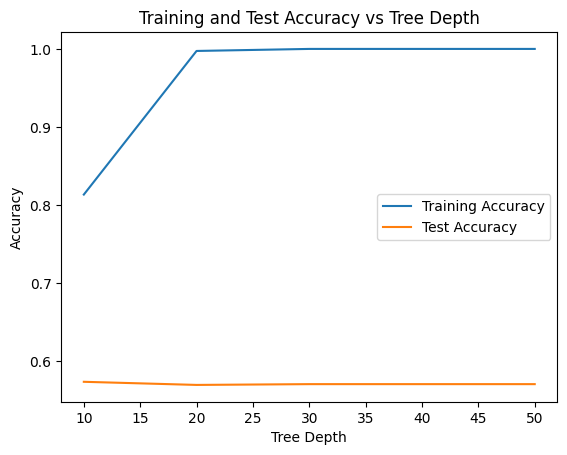

Runtime: 739.69 seconds


In [ ]:
# Block 9
# 4: Decision Tree
# Bullet Point 2


# Test with varying set of depths

# The depths we will choose will be the following: 10,20,30,40,50


start_time = time.time()


class SelfMadeDecisionTreeClassifier:

    def __init__(self, max_depth=5, min_samples_split=2, min_samples_leaf=1):
        # Initialize the Decision Tree Classifier
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def gini_value(self, y):
        # Calculate the Gini impurity for a given set of labels
        counts = Counter(y)  # Count occurrences of each class
        gini = 1 - sum((count / len(y)) ** 2 for count in counts.values())  # Calculate Gini impurity
        return gini

    def split(self, X, y, feature_index, threshold):
        # Split dataset using indices instead of slicing data
        left_indices = X[:, feature_index] < threshold
        right_indices = ~left_indices
        return np.where(left_indices)[0], np.where(right_indices)[0]

    def best_split(self, X, y):
        # Find the best feature and threshold to split the dataset
        best_feature, best_threshold, best_gini = None, None, float('inf')

        for feature_index in range(X.shape[1]):
            # Sort feature values and corresponding labels
            sorted_indices = X[:, feature_index].argsort()
            X_sorted, y_sorted = X[sorted_indices], y[sorted_indices]

            # Initialize cumulative counts for left and right subsets
            left_counts = Counter()
            right_counts = Counter(y_sorted)
            n = len(y_sorted)

            for i in range(1, n):  # Iterate through possible thresholds
                # Move the current sample from right to left
                label = y_sorted[i - 1]
                left_counts[label] += 1
                right_counts[label] -= 1

                # Skip redundant thresholds
                if X_sorted[i, feature_index] == X_sorted[i - 1, feature_index]:
                    continue

                # Compute the Gini impurity for the split
                left_size = i
                right_size = n - i
                left_gini = 1 - sum((count / left_size) ** 2 for count in left_counts.values())
                right_gini = 1 - sum((count / right_size) ** 2 for count in right_counts.values())
                gini = (left_size / n) * left_gini + (right_size / n) * right_gini

                # Update the best split if this split has lower Gini
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_index
                    best_threshold = (X_sorted[i - 1, feature_index] + X_sorted[i, feature_index]) / 2

        return best_feature, best_threshold



    def _split_gini(self, X_feature, y, threshold):
        # Compute the Gini impurity of a split
        left_indices = X_feature < threshold
        y_left, y_right = y[left_indices], y[~left_indices]  # Split target values

        # Calculate weighted Gini impurity
        gini = (len(y_left) / len(y)) * self.gini_value(y_left) + (len(y_right) / len(y)) * self.gini_value(y_right)
        return gini

    def build_tree(self, X, y, indices=None, depth=0):
        # Recursively build the decision tree using indices to avoid data slicing.

        # Initialize indices for the root node
        if indices is None:
            indices = np.arange(len(y))

        # Extract the current subset of the data
        current_X = X[indices]
        current_y = y[indices]

        # Stopping conditions
        if (
            depth == self.max_depth or
            len(np.unique(current_y)) == 1 or
            len(current_y) < self.min_samples_split
        ):
            return Counter(current_y).most_common(1)[0][0]  # Return majority class as a leaf node

        # Find the best split
        feature_index, threshold = self.best_split(current_X, current_y)
        if feature_index is None or threshold is None:
            return Counter(current_y).most_common(1)[0][0]  # Return majority class if no valid split

        # Split data using indices
        left_indices = indices[current_X[:, feature_index] < threshold]
        right_indices = indices[current_X[:, feature_index] >= threshold]

        # Ensure minimum samples in leaf nodes
        if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
            return Counter(current_y).most_common(1)[0][0]

        # Calculate Gini improvement for pruning
        gini_parent = self.gini_value(current_y)
        gini_left = self.gini_value(y[left_indices])
        gini_right = self.gini_value(y[right_indices])
        gini_improvement = gini_parent - (len(left_indices) / len(current_y)) * gini_left - (len(right_indices) / len(current_y)) * gini_right

        if gini_improvement < 1e-3:  # Prune if improvement is too small
            return Counter(current_y).most_common(1)[0][0]

        # Recursively build subtrees
        return {
            "feature_index": feature_index,
            "threshold": threshold,
            "left": self.build_tree(X, y, left_indices, depth + 1),
            "right": self.build_tree(X, y, right_indices, depth + 1),
        }



    def fit(self, X, y):
        # Train the decision tree on the given dataset
        self.tree = self.build_tree(X, y)  # Build the tree

    def predict_single(self, x, tree):
        # Predict the class for a single sample
        if isinstance(tree, dict):  # If the node is not a leaf
            if x[tree["feature_index"]] < tree["threshold"]:
                return self.predict_single(x, tree["left"])
            else:
                return self.predict_single(x, tree["right"])
        else:
            return tree  # Return leaf value

    def predict(self, X):
        # Predict the class for a dataset
        def traverse_tree(x, tree):
            # Traverse the tree iteratively
            while isinstance(tree, dict):
                if x[tree["feature_index"]] < tree["threshold"]:
                    tree = tree["left"]
                else:
                    tree = tree["right"]
            return tree

        return np.array([traverse_tree(x, self.tree) for x in X])




  # End of SelfMadeDecisitionTreeClassifer


# load PCA features and labels
training_features_PCA = np.load("training_features_reduced_PCA.npy")
training_labels = np.load("training_labels.npy")
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")


tree_depths = [10, 20, 30, 40, 50]
train_accuracies_list = []
test_accuracies_list = []



for depth in tree_depths:
    print(f"Training with depth {depth}")
    decision_tree = SelfMadeDecisionTreeClassifier(max_depth = depth)
    decision_tree.fit(training_features_PCA, training_labels)


    # Save this tree model at this iteration of the depth value to be used in bullet point 4
    model_path = f"decision_tree_depth_{depth}.pkl" # | decision_tree_depth_10.pkl | decision_tree_depth_20.pkl | decision_tree_depth_30.pkl | decision_tree_depth_40.pkl | decision_tree_depth_50.pkl
    with open(model_path, 'wb') as f:
        pickle.dump(decision_tree.tree, f)
    print(f"Decision tree  of depth {depth} saved at {model_path}")


    # Training and Test Predictions
    train_predictions = decision_tree.predict(training_features_PCA)
    test_predictions = decision_tree.predict(test_features_PCA)

    # Training and Test Accuracies
    train_accuracy = accuracy_score(training_labels, train_predictions)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    # Append to Training and Test Accuracy list
    train_accuracies_list.append(train_accuracy)
    test_accuracies_list.append(test_accuracy)

    print(f"Depth: {depth}, Training Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    print("\n")


# Plot training and test accuracy
plt.plot(tree_depths, train_accuracies_list, label="Training Accuracy")
plt.plot(tree_depths, test_accuracies_list, label="Test Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy vs Tree Depth")
plt.legend()
plt.show()



end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds") # 739.69 seconds t4


In [ ]:
# Block 10
# 4: Decision Tree
# Bullet Point 3
# We will use sklearn Dicision Tree Classifier to redo bullet point 1


from sklearn.tree import DecisionTreeClassifier

start_time = time.time()

# Load PCA features and labels
training_features_PCA = np.load("training_features_reduced_PCA.npy")
training_labels = np.load("training_labels.npy")
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")

# Use skLearn Dcision Tree Classifier

decision_tree_sklearn = DecisionTreeClassifier(criterion = "gini",max_depth=50)

# Train the model
decision_tree_sklearn.fit(training_features_PCA, training_labels)


# Saving the sklearn trained Decision Tree to be used in bullet point 4
decision_tree_sklearn_path = "decision_tree_bp3.pkl"  #
with open(decision_tree_sklearn_path, 'wb') as f:
    pickle.dump(decision_tree_sklearn, f)
print(f"Decision tree (sklearn) saved at {decision_tree_sklearn_path}")


# Prediction test set
y_prediction_decisiontree_sklearn = decision_tree_sklearn.predict(test_features_PCA)

# Print the accuracy and runtime
print("Accuracy:", accuracy_score(test_labels, y_prediction_decisiontree_sklearn))
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds") # 3.94 sec t4



Decision tree (sklearn) saved at decision_tree_bp3.pkl
Accuracy: 0.547
Runtime: 3.76 seconds


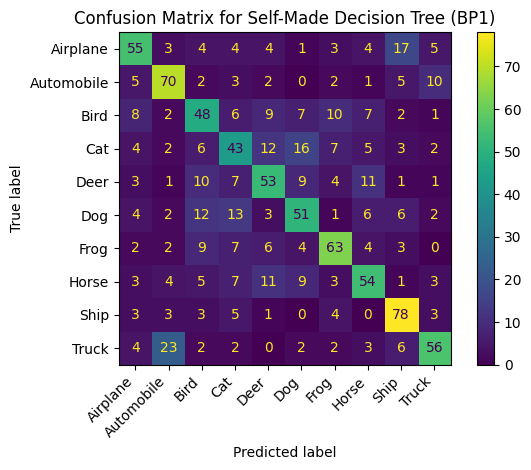


Classification Report for Decision Tree BP1:
              precision    recall  f1-score   support

    Airplane       0.60      0.55      0.58       100
  Automobile       0.62      0.70      0.66       100
        Bird       0.48      0.48      0.48       100
         Cat       0.44      0.43      0.44       100
        Deer       0.52      0.53      0.53       100
         Dog       0.52      0.51      0.51       100
        Frog       0.64      0.63      0.63       100
       Horse       0.57      0.54      0.55       100
        Ship       0.64      0.78      0.70       100
       Truck       0.67      0.56      0.61       100

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000


-------------------------------------------------------------------------------------------



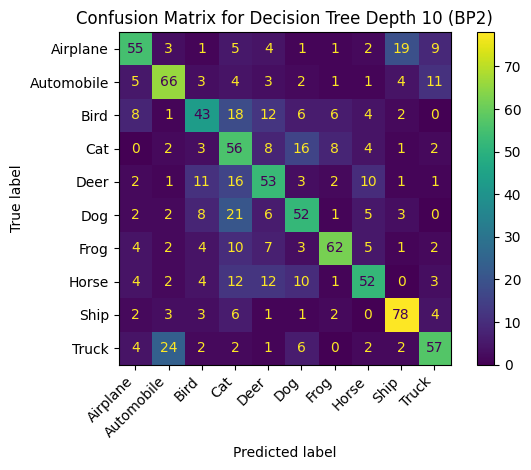



Classification Report for Decision Tree Depth 10:
              precision    recall  f1-score   support

    Airplane       0.64      0.55      0.59       100
  Automobile       0.62      0.66      0.64       100
        Bird       0.52      0.43      0.47       100
         Cat       0.37      0.56      0.45       100
        Deer       0.50      0.53      0.51       100
         Dog       0.52      0.52      0.52       100
        Frog       0.74      0.62      0.67       100
       Horse       0.61      0.52      0.56       100
        Ship       0.70      0.78      0.74       100
       Truck       0.64      0.57      0.60       100

    accuracy                           0.57      1000
   macro avg       0.59      0.57      0.58      1000
weighted avg       0.59      0.57      0.58      1000


-------------------------------------------------------------------------------------------



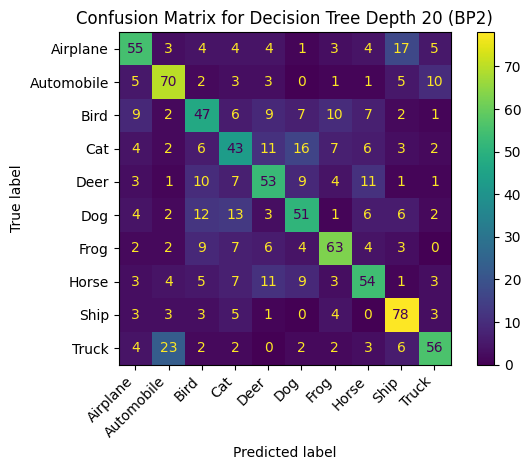



Classification Report for Decision Tree Depth 20:
              precision    recall  f1-score   support

    Airplane       0.60      0.55      0.57       100
  Automobile       0.62      0.70      0.66       100
        Bird       0.47      0.47      0.47       100
         Cat       0.44      0.43      0.44       100
        Deer       0.52      0.53      0.53       100
         Dog       0.52      0.51      0.51       100
        Frog       0.64      0.63      0.64       100
       Horse       0.56      0.54      0.55       100
        Ship       0.64      0.78      0.70       100
       Truck       0.67      0.56      0.61       100

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000


-------------------------------------------------------------------------------------------



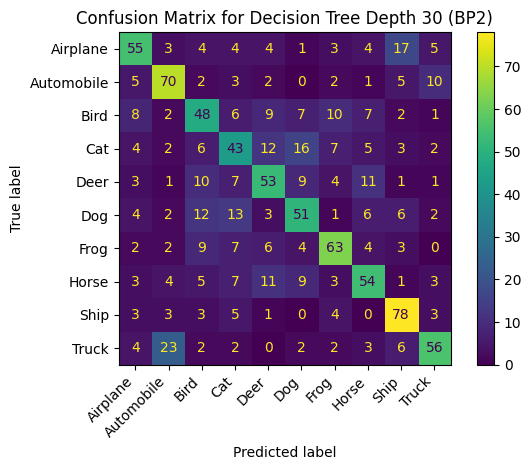



Classification Report for Decision Tree Depth 30:
              precision    recall  f1-score   support

    Airplane       0.60      0.55      0.58       100
  Automobile       0.62      0.70      0.66       100
        Bird       0.48      0.48      0.48       100
         Cat       0.44      0.43      0.44       100
        Deer       0.52      0.53      0.53       100
         Dog       0.52      0.51      0.51       100
        Frog       0.64      0.63      0.63       100
       Horse       0.57      0.54      0.55       100
        Ship       0.64      0.78      0.70       100
       Truck       0.67      0.56      0.61       100

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000


-------------------------------------------------------------------------------------------



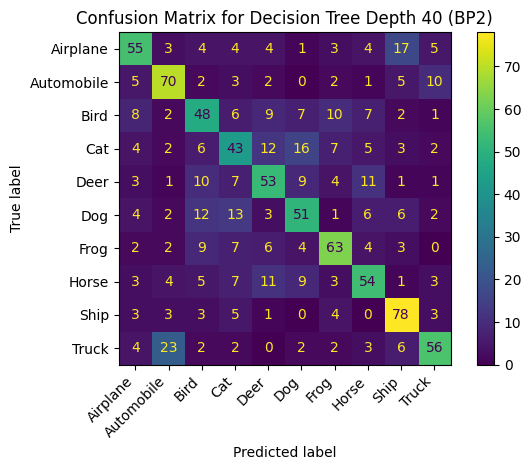



Classification Report for Decision Tree Depth 40:
              precision    recall  f1-score   support

    Airplane       0.60      0.55      0.58       100
  Automobile       0.62      0.70      0.66       100
        Bird       0.48      0.48      0.48       100
         Cat       0.44      0.43      0.44       100
        Deer       0.52      0.53      0.53       100
         Dog       0.52      0.51      0.51       100
        Frog       0.64      0.63      0.63       100
       Horse       0.57      0.54      0.55       100
        Ship       0.64      0.78      0.70       100
       Truck       0.67      0.56      0.61       100

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000


-------------------------------------------------------------------------------------------



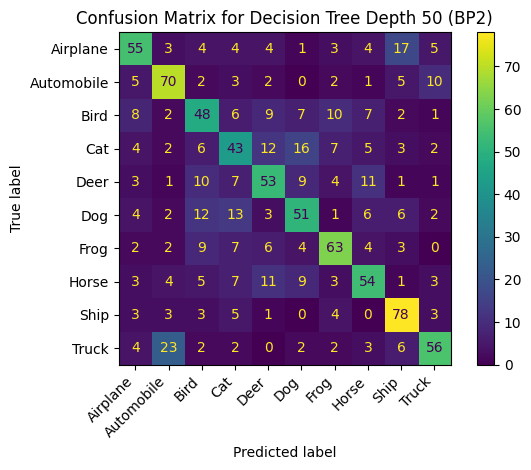



Classification Report for Decision Tree Depth 50:
              precision    recall  f1-score   support

    Airplane       0.60      0.55      0.58       100
  Automobile       0.62      0.70      0.66       100
        Bird       0.48      0.48      0.48       100
         Cat       0.44      0.43      0.44       100
        Deer       0.52      0.53      0.53       100
         Dog       0.52      0.51      0.51       100
        Frog       0.64      0.63      0.63       100
       Horse       0.57      0.54      0.55       100
        Ship       0.64      0.78      0.70       100
       Truck       0.67      0.56      0.61       100

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000


-------------------------------------------------------------------------------------------



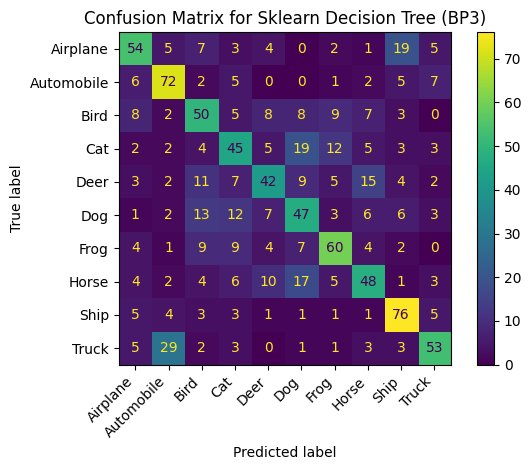


Classification Report for Decision Tree BP3:


Classification Report for Sklearn Decision Tree BP3:
              precision    recall  f1-score   support

    Airplane       0.59      0.54      0.56       100
  Automobile       0.60      0.72      0.65       100
        Bird       0.48      0.50      0.49       100
         Cat       0.46      0.45      0.45       100
        Deer       0.52      0.42      0.46       100
         Dog       0.43      0.47      0.45       100
        Frog       0.61      0.60      0.60       100
       Horse       0.52      0.48      0.50       100
        Ship       0.62      0.76      0.68       100
       Truck       0.65      0.53      0.59       100

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.54      1000
weighted avg       0.55      0.55      0.54      1000

Accuracy of Self-Made Decision Tree (BP1): 57.10%
Accuracy of Decision Tree (Depth 10, BP2): 57.40%
Accuracy of Decision Tree (Depth 20, BP2

In [7]:
# Block 11
# 4: Decision Tree
# Bullet Point 4

from collections import Counter
import pickle
import numpy as np
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Load PCA features and labels
training_features_PCA = np.load("training_features_reduced_PCA.npy")
training_labels = np.load("training_labels.npy")
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")


# Open the the decision tree from bp1, bp3

with open("decision_tree_bp1.pkl", 'rb') as f:
    decision_tree_bp1 = pickle.load(f)


with open("decision_tree_bp3.pkl", 'rb') as f:
    decision_tree_bp3 = pickle.load(f)


    # Evalauting Bp1
def predict_tree(model,X):

    def traverse_tree(x, tree):
        # Traverse the tree recursively until a leaf is reached
        while isinstance(tree, dict):  # If the current node is not a leaf
            if x[tree["feature_index"]] < tree["threshold"]:
                tree = tree["left"]
            else:
                tree = tree["right"]
        return tree  # Leaf node: return class label

    return np.array([traverse_tree(x, model) for x in X])


# Evaluate BP1: Predict using the manually implemented decision tree
y_pred_bp1 = predict_tree(decision_tree_bp1, test_features_PCA)
accuracy_bp1 = accuracy_score(test_labels, y_pred_bp1)

# Sklearn treee Prediction set
y_pred_bp3 = decision_tree_bp3.predict(test_features_PCA)
accuracy_bp3 = accuracy_score(test_labels, y_pred_bp3)


# Confusion Matrix and Classification Report for Decision Tree BP1
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

cm_bp1 = confusion_matrix(test_labels, y_pred_bp1)
disp_bp1 = ConfusionMatrixDisplay(confusion_matrix=cm_bp1, display_labels=class_names)
disp_bp1.plot()
plt.title("Confusion Matrix for Self-Made Decision Tree (BP1)")
plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
plt.tight_layout()
plt.show()
print("\nClassification Report for Decision Tree BP1:")
print(classification_report(test_labels, y_pred_bp1, target_names=class_names))

print("\n-------------------------------------------------------------------------------------------\n")


depths = [10,20,30,40,50]
accuracy_bp2 = {}

# Generate Confusion MAtrix and Classification Report for all the depths of decision trees in bp2
for depth in depths:
    # Load the saved decision tree for the current depth
    with open(f"decision_tree_depth_{depth}.pkl", 'rb') as f:
        decision_tree_depth = pickle.load(f)

    # Predict using the manually implemented decision tree for the current depth
    y_pred_bp2 = predict_tree(decision_tree_depth, test_features_PCA)
    accuracy = accuracy_score(test_labels, y_pred_bp2)
    accuracy_bp2[depth] = accuracy

    # Confusion Matrix for Current Depth
    cm_bp2 = confusion_matrix(test_labels, y_pred_bp2)
    disp_bp2 = ConfusionMatrixDisplay(confusion_matrix=cm_bp2, display_labels=class_names)
    disp_bp2.plot()
    plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
    plt.title(f"Confusion Matrix for Decision Tree Depth {depth} (BP2)")
    plt.tight_layout()
    plt.show()

    # Generate the classification report
    report = classification_report(test_labels, y_pred_bp2,target_names=class_names)
    # Add additional formatting
    print("\n" + "=======================================================================================")
    print(f"\nClassification Report for Decision Tree Depth {depth}:")
    print("=======================================================================================")
    print(report)
    print("=======================================================================================")
    print("\n-------------------------------------------------------------------------------------------\n")






# Confusion Matrix and Classification Report for Decision Tree BP3

cm_bp3 = confusion_matrix(test_labels, y_pred_bp3)
disp_bp3 = ConfusionMatrixDisplay(confusion_matrix=cm_bp3, display_labels=class_names)
disp_bp3.plot()
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
plt.title("Confusion Matrix for Sklearn Decision Tree (BP3)")
plt.tight_layout()
plt.show()

# Generate the classification report
print("\nClassification Report for Decision Tree BP3:")
report = classification_report(test_labels, y_pred_bp3,target_names=class_names)
print("\n" + "=======================================================================================")
print("\nClassification Report for Sklearn Decision Tree BP3:")
print("=======================================================================================")
print(report)
print("=======================================================================================")


# Print the Accuracy for all variants of Decision Tree
print(f"Accuracy of Self-Made Decision Tree (BP1): {accuracy_bp1 * 100:.2f}%")

for depth, acc in accuracy_bp2.items():  # Print accuracies for all depths in BP2
    print(f"Accuracy of Decision Tree (Depth {depth}, BP2): {acc * 100:.2f}%")

print(f"Accuracy of Sklearn Decision Tree (BP3): {accuracy_bp3 * 100:.2f}%")

<h1 style="text-align: left; font-size: 70px;">5 - Multi-Layer Perceptron</h1>

<p> 1. Implement a three-layer MLP (details below) and train it on the feature vectors of the CIFAR-10’s
training set. The details of the MLP architecture are: </p>


*   Linear(50, 512) - ReLU
*   Linear(512, 512) - BatchNorm(512) - ReLU
*   Linear(512, 10)

<p> You should use the cross-entropy loss torch.nn.CrossEntropyLoss for training. Also, use the SGD
optimizer with momentum=0.9.</p>






In [ ]:
# Block 12
# 5: Multi-Layer Perceptron
## Bullet Point 1

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.decomposition import PCA # We need this to reshape the PCA faetures from 64x512 to a 50x512

# We will be wokring with pyTorch Tensors in this section when constructin a multi-layer perceptron
# and optim to utulize SGD optimizer


start_time = time.time()


# Load PCA features and labels
training_features_PCA = np.load("training_features_reduced_PCA.npy")
training_labels = np.load("training_labels.npy")
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")


# Resahpe the PCA features to be a 50x512 from a 64x512
training_features_PCA_50x512 = training_features_PCA[:, :50]  # Select first 50 features for training
test_features_PCA_50x512 = test_features_PCA[:, :50]



# Convert to pytorch Tensors
X_train = torch.tensor(training_features_PCA_50x512, dtype=torch.float32)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(test_features_PCA_50x512, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)




# We need a dataloader for batching (size 64)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)


# Multi-Layer Perceptron Architecture/Model

class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()

        self.fc1 = nn.Linear(50, 512)           # 50x512 Input Layer
        self.ReLU1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 512)          # 512x512 Hidden Layer
        self.BatchNorm2 = nn.BatchNorm1d(512)
        self.ReLU2 = nn.ReLU()

        self.fc3 = nn.Linear(512, 10)           # 512x10 Output Layer


    # Forward Pass
    def forward(self, x):
        x = self.ReLU1(self.fc1(x))
        x = self.ReLU2(self.BatchNorm2(self.fc2(x)))
        x = self.fc3(x)
        return x


# Initialize the model
model = MultiLayerPerceptron()
criterion = nn.CrossEntropyLoss() # said to use in question
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # said to use momentum 0.09 in question


# Move to GPU from CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Training Phase
for epoch in range(100):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()               # Zero Gradient
        outputs = model(x_batch)            # Forward Pass
        loss = criterion(outputs, y_batch)  # Loss Function
        loss.backward()                     # Backpropogation
        optimizer.step()                    # Update Weights

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")




# Save the MLP model using torch.save

mlp_model_path = "mlp_model_bp1.pth"  # Path to save the model
torch.save(model.state_dict(), mlp_model_path)  # Save model state_dict
print(f"Trained Multi-Layer Perceptron model saved at {mlp_model_path}")


# Testing Phase
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

# Print accuracy and running time
print(f"Accuracy: {100 * correct / total}% for 100 epochs")
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")




# Over Each epoch the training loss value decreases and decrases, this suggest that the model is learning at each iteration and eventually converges




Epoch 1, Loss: 1.0972239126133014
Epoch 2, Loss: 0.755665610485439
Epoch 3, Loss: 0.6568183898925781
Epoch 4, Loss: 0.5821782622156264
Epoch 5, Loss: 0.5242447543747818
Epoch 6, Loss: 0.47442698101454145
Epoch 7, Loss: 0.41679118932047976
Epoch 8, Loss: 0.3411315553173234
Epoch 9, Loss: 0.30412353292296207
Epoch 10, Loss: 0.2833693118035039
Epoch 11, Loss: 0.247298033082787
Epoch 12, Loss: 0.1858183548231668
Epoch 13, Loss: 0.17975896908135353
Epoch 14, Loss: 0.12660664876427832
Epoch 15, Loss: 0.13567330254406867
Epoch 16, Loss: 0.09967848078548154
Epoch 17, Loss: 0.08205683491652525
Epoch 18, Loss: 0.07888102814366546
Epoch 19, Loss: 0.05028306110467337
Epoch 20, Loss: 0.05152760052322587
Epoch 21, Loss: 0.04997304593554781
Epoch 22, Loss: 0.05008659688637981
Epoch 23, Loss: 0.03646753280411793
Epoch 24, Loss: 0.042657743255265904
Epoch 25, Loss: 0.0761531487319477
Epoch 26, Loss: 0.04292295064447047
Epoch 27, Loss: 0.039877252865441234
Epoch 28, Loss: 0.06773681882061536
Epoch 29, L

<p> 2. Experiment by varying the depth of the network by adding or removing layers. Observe and document
how the depth of the MLP influences the model’s ability to learn and generalize from the data. </p>

In [ ]:
# Block 13
# 5: Multi-Layer Perceptron
## Bullet Point 2

# We are essentially using the same code as the previous question but with some modification to test the depths of this network

# Experiment with Varying Depths of the MLP
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn


# Initialize the model
start_time = time.time()


# Load PCA features and labels
training_features_PCA = np.load("training_features_reduced_PCA.npy")
training_labels = np.load("training_labels.npy")
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")

# Select the first 50 features for training and testing
training_features_PCA_50x512 = training_features_PCA[:, :50]
test_features_PCA_50x512 = test_features_PCA[:, :50]

# Convert to PyTorch Tensors
X_train = torch.tensor(training_features_PCA_50x512, dtype=torch.float32)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(test_features_PCA_50x512, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

# Dataloader for batching (size 64)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)


class MultiLayerPerceptronDepth(nn.Module):
    def __init__(self, depth):
        super(MultiLayerPerceptronDepth, self).__init__()
        layers = []

        # input layer
        layers.append(nn.Linear(50, 512))
        layers.append(nn.ReLU())


        # input n hidden layers based on the depth input
        for _ in range(depth):
            layers.append(nn.Linear(512, 512))
            layers.append(nn.BatchNorm1d(512))
            layers.append(nn.ReLU())

        # output layer
        layers.append(nn.Linear(512, 10))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


def train_and_save(depth):

    model = MultiLayerPerceptronDepth(depth)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # CPU --> GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    # Training Phase
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
        # We are removing this since it makes the code harder to read



    # Save the trained model for this depth will need for the confusion matrix and classification report
    model_path = f"mlp_model_depth_{depth}_bp2.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model for depth {depth} saved at {model_path}")




    # Testing Phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    # Print Accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}% for {depth} layers")
    return accuracy


# Now we test this with the following depths [1,2,3,...,17,18,19,20]

accuracy_results_depths = {}
for depth in range(21):
    if depth == 0:
        continue
    accuracy_results_depths[depth] = train_and_save(depth)


# Print the Accuracy per depth and runtime
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")

""" Summary:
    Accuracy will keep decreasing very steadily as the number of depths increase. The increase in number of depths
    does not really seem to do much for this specific problem we are dealing with. Seems to be overfitting training data when using higher depths.
    Dataset most likely not complex enough to warrant an increase in depth layers.
"""


Model for depth 1 saved at mlp_model_depth_1_bp2.pth
Accuracy: 69.3% for 1 layers
Model for depth 2 saved at mlp_model_depth_2_bp2.pth
Accuracy: 69.1% for 2 layers
Model for depth 3 saved at mlp_model_depth_3_bp2.pth
Accuracy: 68.3% for 3 layers
Model for depth 4 saved at mlp_model_depth_4_bp2.pth
Accuracy: 67.8% for 4 layers
Model for depth 5 saved at mlp_model_depth_5_bp2.pth
Accuracy: 67.8% for 5 layers
Model for depth 6 saved at mlp_model_depth_6_bp2.pth
Accuracy: 68.4% for 6 layers
Model for depth 7 saved at mlp_model_depth_7_bp2.pth
Accuracy: 66.6% for 7 layers
Model for depth 8 saved at mlp_model_depth_8_bp2.pth
Accuracy: 67.4% for 8 layers
Model for depth 9 saved at mlp_model_depth_9_bp2.pth
Accuracy: 66.6% for 9 layers
Model for depth 10 saved at mlp_model_depth_10_bp2.pth
Accuracy: 66.4% for 10 layers
Model for depth 11 saved at mlp_model_depth_11_bp2.pth
Accuracy: 66.9% for 11 layers
Model for depth 12 saved at mlp_model_depth_12_bp2.pth
Accuracy: 69.1% for 12 layers
Model f

' INTERPRETATION:\n    Observe and document how the depth of the MLP influences the model’s ability to learn and generalize from the data.\n\n    Accuracy will keep decreasing very steadily as the number of depths increase. The increase in number of depths\n    does not really seem to do much for this specific problem we are dealing with.\n\n'

<p>3. Vary the sizes of the hidden layers. Experiment with larger and smaller sizes. Analyze the trade-offs in
computational cost and performance of the model.</p>

In [ ]:
# Block 14
# 5: Multi-Layer Perceptron
## Bullet Point 3
# We do the same logic as bullet point 2 but now the hidden layers are varrying in sizes not depth
from torch.utils.data import DataLoader, TensorDataset
start_time = time.time()



# Load PCA features and labels
training_features_PCA = np.load("training_features_reduced_PCA.npy")
training_labels = np.load("training_labels.npy")
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")


# Resahpe the PCA features to be a 50x512 from a 64x512
training_features_PCA_50x512 = training_features_PCA[:, :50]  # Select first 50 features for training
test_features_PCA_50x512 = test_features_PCA[:, :50]


# Convert to pytorch Tensors
X_train = torch.tensor(training_features_PCA_50x512, dtype=torch.float32)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(test_features_PCA_50x512, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)



# We need a dataloader for batching (size 64)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)


# Multi-Layer Perceptron Architecture/Model with varying hidden layer size(dimensions)


class MultiLayerPerceptronHiddenLayerSize(nn.Module):
    def __init__(self, hidden_size):
        super(MultiLayerPerceptronHiddenLayerSize, self).__init__()

        self.fc1 = nn.Linear(50, hidden_size)
        self.ReLU1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.BatchNorm2 = nn.BatchNorm1d(hidden_size)
        self.ReLU2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_size, 10)


    # Forward Pass
    def forward(self, x):
        x = self.ReLU1(self.fc1(x))
        x = self.ReLU2(self.BatchNorm2(self.fc2(x)))
        x = self.fc3(x)
        return x


def train_and_save_and_evaluate_hiddenLayer(hidden_size):
  model = MultiLayerPerceptronHiddenLayerSize(hidden_size)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


  # CPU --> GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)


  # Training Phase
  for epoch in range(100):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


  # Save the model
  model_path = f"mlp_hidden_layer_size_{hidden_size}_bp3.pth"
  torch.save(model.state_dict(), model_path)
  print(f"Model with hidden layer size {hidden_size} saved at {model_path}")


  # Testing Phase
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for x_batch, y_batch in test_loader:
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          _, predicted = torch.max(outputs.data, 1)
          total += y_batch.size(0)
          correct += (predicted == y_batch).sum().item()

  # Print Accuracy
  accuracy = 100 * correct / total
  print(f"Accuracy: {accuracy}% for {hidden_size} hidden layers")
  return accuracy


# For this section we will use the following dimensions/size for the hidden layers = [128, 256, 512, 1024, 2048]
accuracy_results_hiddenlayersize = {}


for hiddenlayer_size in [128, 256, 512, 1024, 2048]:
    accuracy_results_hiddenlayersize[hiddenlayer_size] = train_and_save_and_evaluate_hiddenLayer(hiddenlayer_size)

# Print The accuracy of each hidden layer size and runtime
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds") #


Model with hidden layer size 128 saved at mlp_hidden_layer_size_128_bp3.pth
Accuracy: 68.4% for 128 hidden layers
Model with hidden layer size 256 saved at mlp_hidden_layer_size_256_bp3.pth
Accuracy: 67.9% for 256 hidden layers
Model with hidden layer size 512 saved at mlp_hidden_layer_size_512_bp3.pth
Accuracy: 69.6% for 512 hidden layers
Model with hidden layer size 1024 saved at mlp_hidden_layer_size_1024_bp3.pth
Accuracy: 70.8% for 1024 hidden layers
Model with hidden layer size 2048 saved at mlp_hidden_layer_size_2048_bp3.pth
Accuracy: 69.2% for 2048 hidden layers
Runtime: 79.44 seconds


Evaluating BP1 Model:


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Accuracy: 70.30%


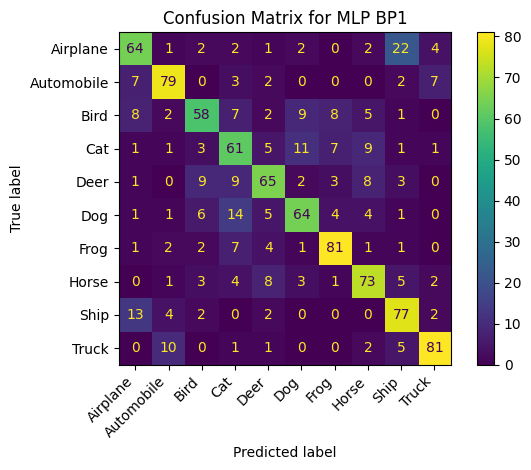


Classification Report for MLP BP1:
              precision    recall  f1-score   support

    Airplane       0.67      0.64      0.65       100
  Automobile       0.78      0.79      0.79       100
        Bird       0.68      0.58      0.63       100
         Cat       0.56      0.61      0.59       100
        Deer       0.68      0.65      0.67       100
         Dog       0.70      0.64      0.67       100
        Frog       0.78      0.81      0.79       100
       Horse       0.70      0.73      0.72       100
        Ship       0.65      0.77      0.71       100
       Truck       0.84      0.81      0.82       100

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000


----------------------------------------------------------------------------

Evaluating BP2 Models:
Depth 1:
Accuracy: 69.30%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


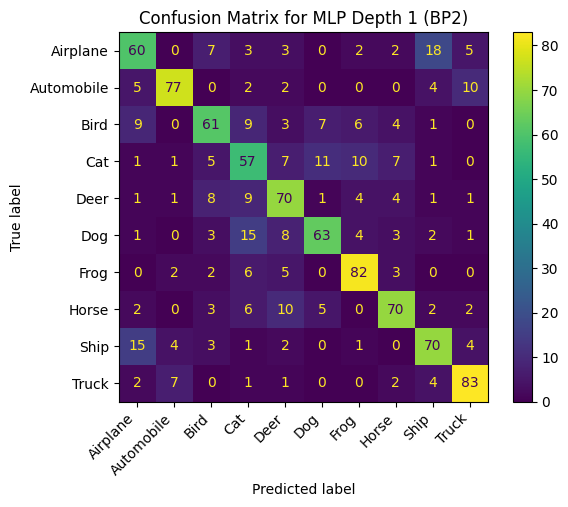


Classification Report for MLP Depth 1 (BP2):
              precision    recall  f1-score   support

    Airplane       0.62      0.60      0.61       100
  Automobile       0.84      0.77      0.80       100
        Bird       0.66      0.61      0.64       100
         Cat       0.52      0.57      0.55       100
        Deer       0.63      0.70      0.66       100
         Dog       0.72      0.63      0.67       100
        Frog       0.75      0.82      0.78       100
       Horse       0.74      0.70      0.72       100
        Ship       0.68      0.70      0.69       100
       Truck       0.78      0.83      0.81       100

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000


-----------------------------------------------------------------------------

Depth 2:
Accuracy: 69.10%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


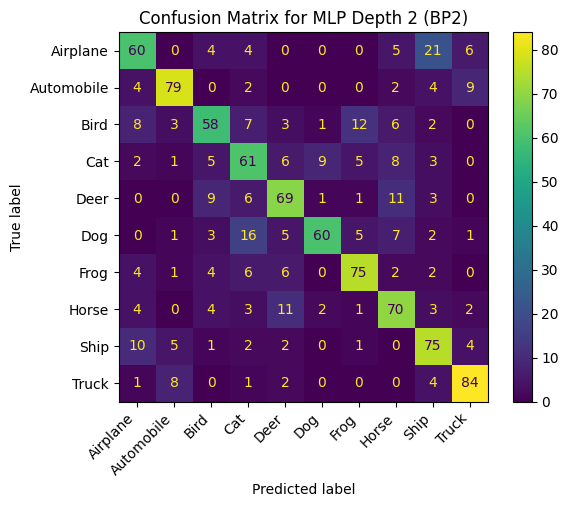


Classification Report for MLP Depth 2 (BP2):
              precision    recall  f1-score   support

    Airplane       0.65      0.60      0.62       100
  Automobile       0.81      0.79      0.80       100
        Bird       0.66      0.58      0.62       100
         Cat       0.56      0.61      0.59       100
        Deer       0.66      0.69      0.68       100
         Dog       0.82      0.60      0.69       100
        Frog       0.75      0.75      0.75       100
       Horse       0.63      0.70      0.66       100
        Ship       0.63      0.75      0.68       100
       Truck       0.79      0.84      0.82       100

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000


-----------------------------------------------------------------------------

Depth 3:
Accuracy: 68.30%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


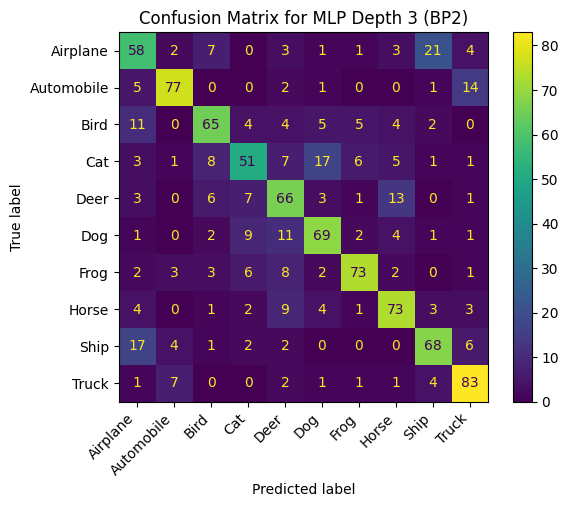


Classification Report for MLP Depth 3 (BP2):
              precision    recall  f1-score   support

    Airplane       0.55      0.58      0.57       100
  Automobile       0.82      0.77      0.79       100
        Bird       0.70      0.65      0.67       100
         Cat       0.63      0.51      0.56       100
        Deer       0.58      0.66      0.62       100
         Dog       0.67      0.69      0.68       100
        Frog       0.81      0.73      0.77       100
       Horse       0.70      0.73      0.71       100
        Ship       0.67      0.68      0.68       100
       Truck       0.73      0.83      0.78       100

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000


-----------------------------------------------------------------------------

Depth 4:
Accuracy: 67.80%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


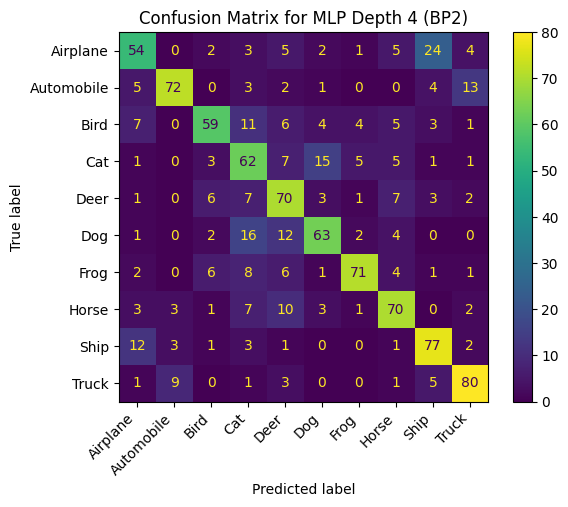


Classification Report for MLP Depth 4 (BP2):
              precision    recall  f1-score   support

    Airplane       0.62      0.54      0.58       100
  Automobile       0.83      0.72      0.77       100
        Bird       0.74      0.59      0.66       100
         Cat       0.51      0.62      0.56       100
        Deer       0.57      0.70      0.63       100
         Dog       0.68      0.63      0.66       100
        Frog       0.84      0.71      0.77       100
       Horse       0.69      0.70      0.69       100
        Ship       0.65      0.77      0.71       100
       Truck       0.75      0.80      0.78       100

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000


-----------------------------------------------------------------------------

Depth 5:
Accuracy: 67.80%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


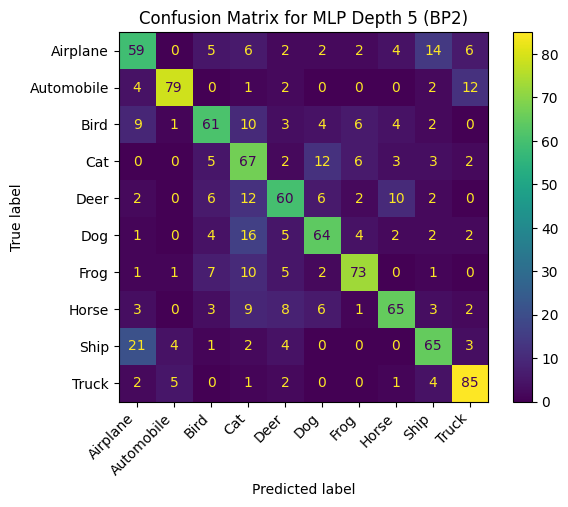


Classification Report for MLP Depth 5 (BP2):
              precision    recall  f1-score   support

    Airplane       0.58      0.59      0.58       100
  Automobile       0.88      0.79      0.83       100
        Bird       0.66      0.61      0.64       100
         Cat       0.50      0.67      0.57       100
        Deer       0.65      0.60      0.62       100
         Dog       0.67      0.64      0.65       100
        Frog       0.78      0.73      0.75       100
       Horse       0.73      0.65      0.69       100
        Ship       0.66      0.65      0.66       100
       Truck       0.76      0.85      0.80       100

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000


-----------------------------------------------------------------------------

Depth 6:
Accuracy: 68.40%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


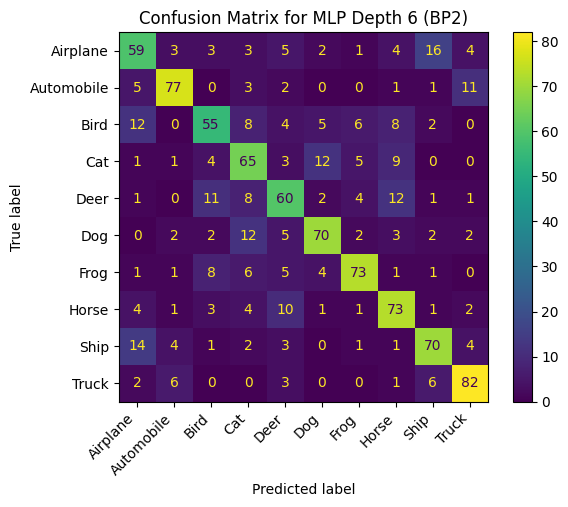


Classification Report for MLP Depth 6 (BP2):
              precision    recall  f1-score   support

    Airplane       0.60      0.59      0.59       100
  Automobile       0.81      0.77      0.79       100
        Bird       0.63      0.55      0.59       100
         Cat       0.59      0.65      0.62       100
        Deer       0.60      0.60      0.60       100
         Dog       0.73      0.70      0.71       100
        Frog       0.78      0.73      0.76       100
       Horse       0.65      0.73      0.69       100
        Ship       0.70      0.70      0.70       100
       Truck       0.77      0.82      0.80       100

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000


-----------------------------------------------------------------------------

Depth 7:
Accuracy: 66.60%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


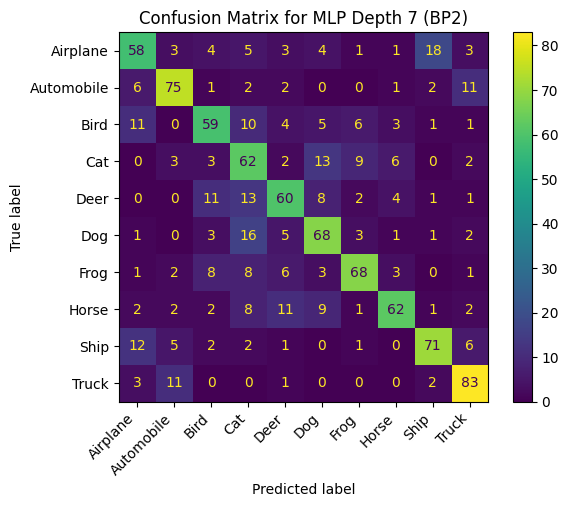


Classification Report for MLP Depth 7 (BP2):
              precision    recall  f1-score   support

    Airplane       0.62      0.58      0.60       100
  Automobile       0.74      0.75      0.75       100
        Bird       0.63      0.59      0.61       100
         Cat       0.49      0.62      0.55       100
        Deer       0.63      0.60      0.62       100
         Dog       0.62      0.68      0.65       100
        Frog       0.75      0.68      0.71       100
       Horse       0.77      0.62      0.69       100
        Ship       0.73      0.71      0.72       100
       Truck       0.74      0.83      0.78       100

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000


-----------------------------------------------------------------------------

Depth 8:
Accuracy: 67.40%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


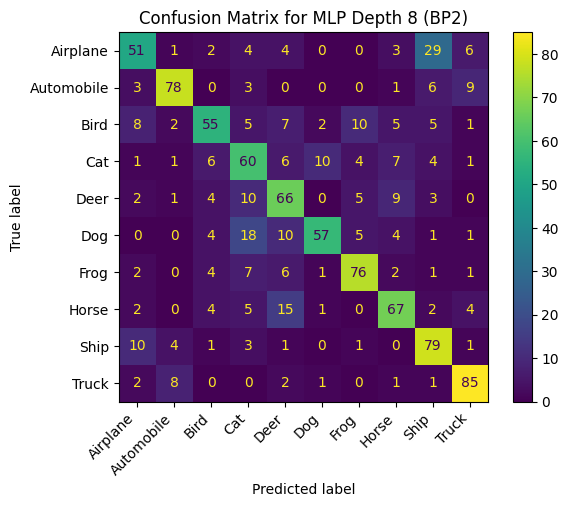


Classification Report for MLP Depth 8 (BP2):
              precision    recall  f1-score   support

    Airplane       0.63      0.51      0.56       100
  Automobile       0.82      0.78      0.80       100
        Bird       0.69      0.55      0.61       100
         Cat       0.52      0.60      0.56       100
        Deer       0.56      0.66      0.61       100
         Dog       0.79      0.57      0.66       100
        Frog       0.75      0.76      0.76       100
       Horse       0.68      0.67      0.67       100
        Ship       0.60      0.79      0.68       100
       Truck       0.78      0.85      0.81       100

    accuracy                           0.67      1000
   macro avg       0.68      0.67      0.67      1000
weighted avg       0.68      0.67      0.67      1000


-----------------------------------------------------------------------------

Depth 9:
Accuracy: 66.60%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


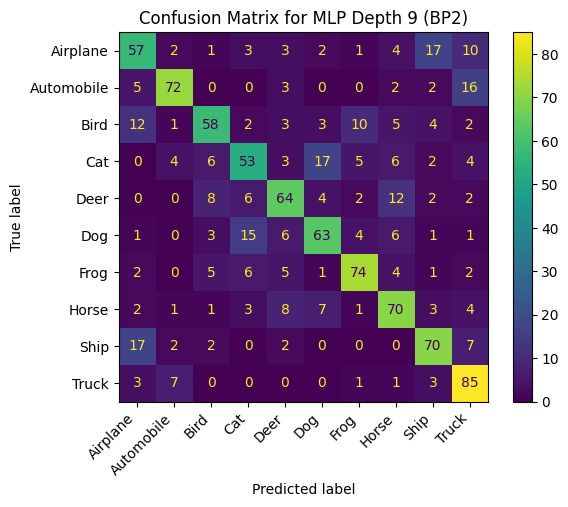


Classification Report for MLP Depth 9 (BP2):
              precision    recall  f1-score   support

    Airplane       0.58      0.57      0.57       100
  Automobile       0.81      0.72      0.76       100
        Bird       0.69      0.58      0.63       100
         Cat       0.60      0.53      0.56       100
        Deer       0.66      0.64      0.65       100
         Dog       0.65      0.63      0.64       100
        Frog       0.76      0.74      0.75       100
       Horse       0.64      0.70      0.67       100
        Ship       0.67      0.70      0.68       100
       Truck       0.64      0.85      0.73       100

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.66      1000
weighted avg       0.67      0.67      0.66      1000


-----------------------------------------------------------------------------

Depth 10:
Accuracy: 66.40%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


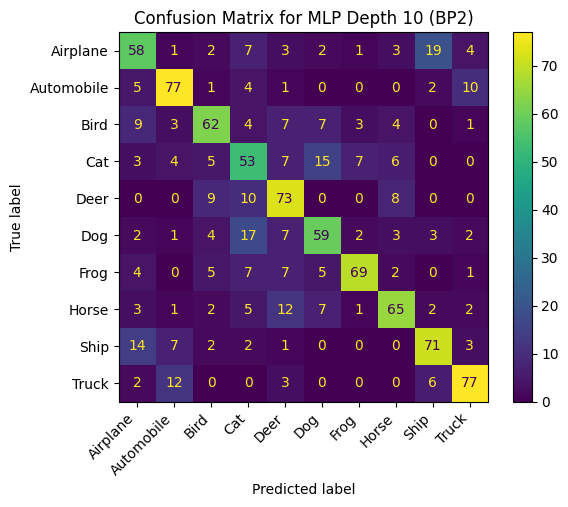


Classification Report for MLP Depth 10 (BP2):
              precision    recall  f1-score   support

    Airplane       0.58      0.58      0.58       100
  Automobile       0.73      0.77      0.75       100
        Bird       0.67      0.62      0.65       100
         Cat       0.49      0.53      0.51       100
        Deer       0.60      0.73      0.66       100
         Dog       0.62      0.59      0.61       100
        Frog       0.83      0.69      0.75       100
       Horse       0.71      0.65      0.68       100
        Ship       0.69      0.71      0.70       100
       Truck       0.77      0.77      0.77       100

    accuracy                           0.66      1000
   macro avg       0.67      0.66      0.67      1000
weighted avg       0.67      0.66      0.67      1000


-----------------------------------------------------------------------------

Depth 11:
Accuracy: 66.90%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


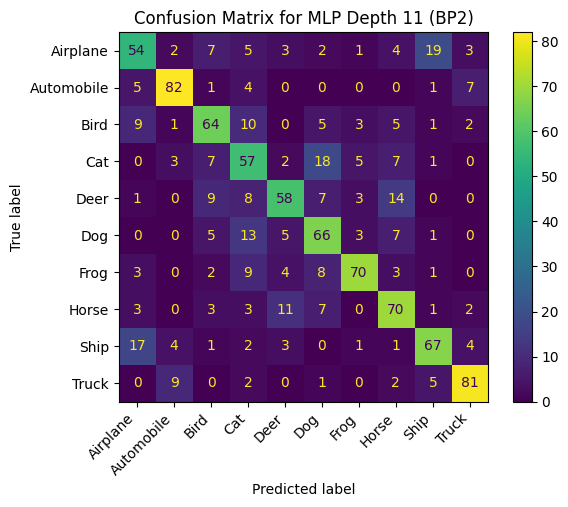


Classification Report for MLP Depth 11 (BP2):
              precision    recall  f1-score   support

    Airplane       0.59      0.54      0.56       100
  Automobile       0.81      0.82      0.82       100
        Bird       0.65      0.64      0.64       100
         Cat       0.50      0.57      0.54       100
        Deer       0.67      0.58      0.62       100
         Dog       0.58      0.66      0.62       100
        Frog       0.81      0.70      0.75       100
       Horse       0.62      0.70      0.66       100
        Ship       0.69      0.67      0.68       100
       Truck       0.82      0.81      0.81       100

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000


-----------------------------------------------------------------------------

Depth 12:
Accuracy: 69.10%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


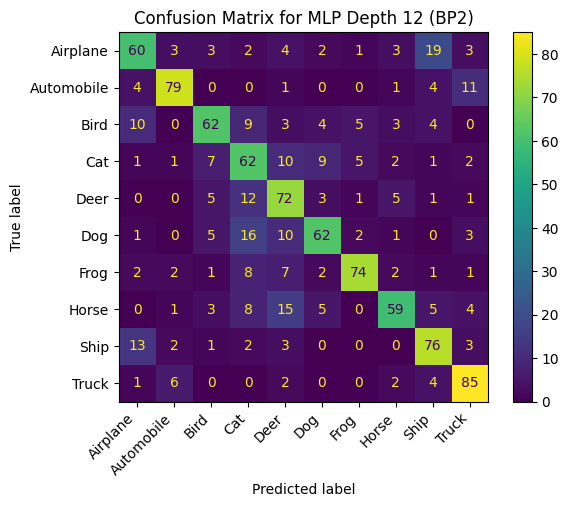


Classification Report for MLP Depth 12 (BP2):
              precision    recall  f1-score   support

    Airplane       0.65      0.60      0.62       100
  Automobile       0.84      0.79      0.81       100
        Bird       0.71      0.62      0.66       100
         Cat       0.52      0.62      0.57       100
        Deer       0.57      0.72      0.63       100
         Dog       0.71      0.62      0.66       100
        Frog       0.84      0.74      0.79       100
       Horse       0.76      0.59      0.66       100
        Ship       0.66      0.76      0.71       100
       Truck       0.75      0.85      0.80       100

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000


-----------------------------------------------------------------------------

Depth 13:
Accuracy: 66.80%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


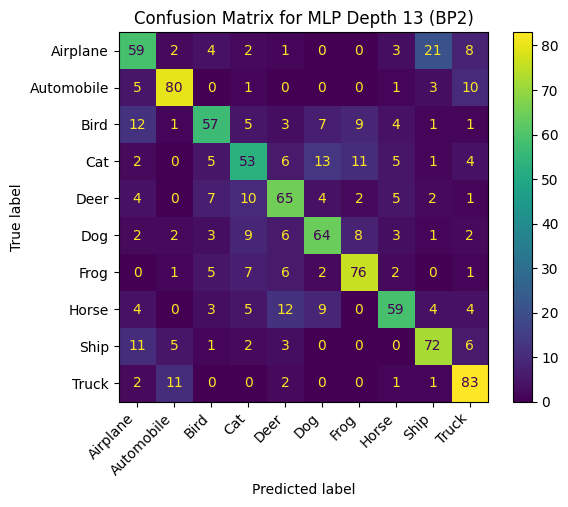


Classification Report for MLP Depth 13 (BP2):
              precision    recall  f1-score   support

    Airplane       0.58      0.59      0.59       100
  Automobile       0.78      0.80      0.79       100
        Bird       0.67      0.57      0.62       100
         Cat       0.56      0.53      0.55       100
        Deer       0.62      0.65      0.64       100
         Dog       0.65      0.64      0.64       100
        Frog       0.72      0.76      0.74       100
       Horse       0.71      0.59      0.64       100
        Ship       0.68      0.72      0.70       100
       Truck       0.69      0.83      0.75       100

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000


-----------------------------------------------------------------------------

Depth 14:
Accuracy: 66.40%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


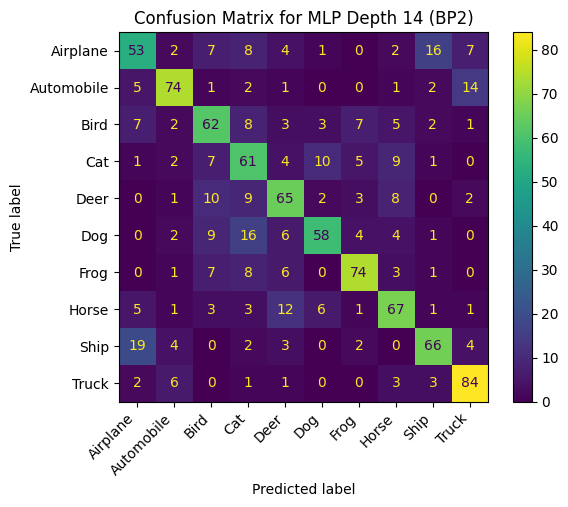


Classification Report for MLP Depth 14 (BP2):
              precision    recall  f1-score   support

    Airplane       0.58      0.53      0.55       100
  Automobile       0.78      0.74      0.76       100
        Bird       0.58      0.62      0.60       100
         Cat       0.52      0.61      0.56       100
        Deer       0.62      0.65      0.63       100
         Dog       0.72      0.58      0.64       100
        Frog       0.77      0.74      0.76       100
       Horse       0.66      0.67      0.66       100
        Ship       0.71      0.66      0.68       100
       Truck       0.74      0.84      0.79       100

    accuracy                           0.66      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       0.67      0.66      0.66      1000


-----------------------------------------------------------------------------

Depth 15:
Accuracy: 66.90%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


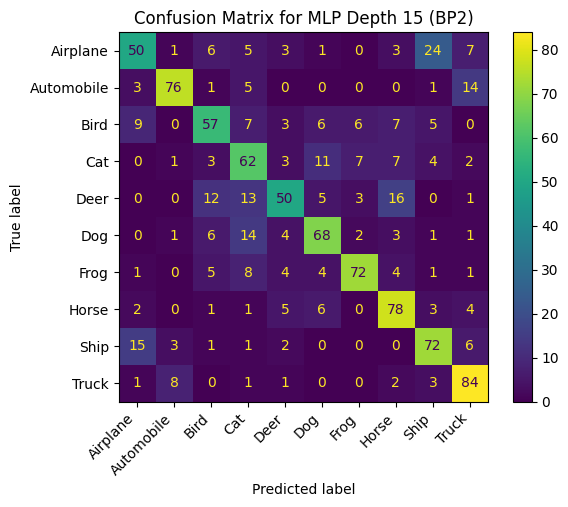


Classification Report for MLP Depth 15 (BP2):
              precision    recall  f1-score   support

    Airplane       0.62      0.50      0.55       100
  Automobile       0.84      0.76      0.80       100
        Bird       0.62      0.57      0.59       100
         Cat       0.53      0.62      0.57       100
        Deer       0.67      0.50      0.57       100
         Dog       0.67      0.68      0.68       100
        Frog       0.80      0.72      0.76       100
       Horse       0.65      0.78      0.71       100
        Ship       0.63      0.72      0.67       100
       Truck       0.70      0.84      0.76       100

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000


-----------------------------------------------------------------------------

Depth 16:
Accuracy: 66.80%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


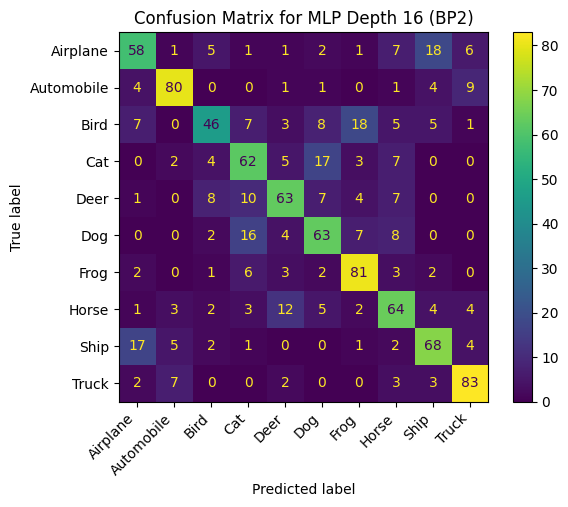


Classification Report for MLP Depth 16 (BP2):
              precision    recall  f1-score   support

    Airplane       0.63      0.58      0.60       100
  Automobile       0.82      0.80      0.81       100
        Bird       0.66      0.46      0.54       100
         Cat       0.58      0.62      0.60       100
        Deer       0.67      0.63      0.65       100
         Dog       0.60      0.63      0.61       100
        Frog       0.69      0.81      0.75       100
       Horse       0.60      0.64      0.62       100
        Ship       0.65      0.68      0.67       100
       Truck       0.78      0.83      0.80       100

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000


-----------------------------------------------------------------------------

Depth 17:
Accuracy: 67.30%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


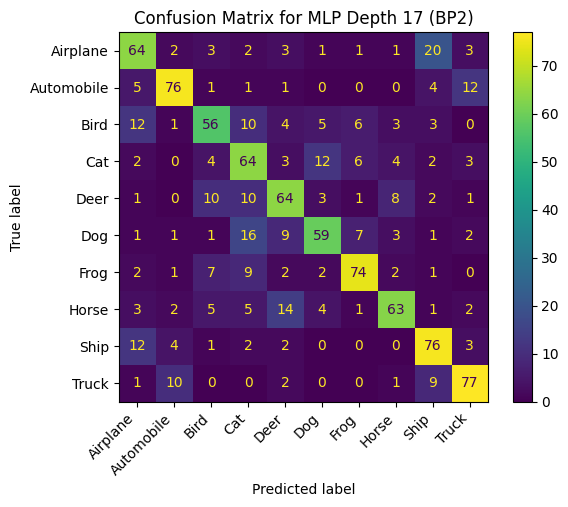


Classification Report for MLP Depth 17 (BP2):
              precision    recall  f1-score   support

    Airplane       0.62      0.64      0.63       100
  Automobile       0.78      0.76      0.77       100
        Bird       0.64      0.56      0.60       100
         Cat       0.54      0.64      0.58       100
        Deer       0.62      0.64      0.63       100
         Dog       0.69      0.59      0.63       100
        Frog       0.77      0.74      0.76       100
       Horse       0.74      0.63      0.68       100
        Ship       0.64      0.76      0.69       100
       Truck       0.75      0.77      0.76       100

    accuracy                           0.67      1000
   macro avg       0.68      0.67      0.67      1000
weighted avg       0.68      0.67      0.67      1000


-----------------------------------------------------------------------------

Depth 18:
Accuracy: 65.60%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


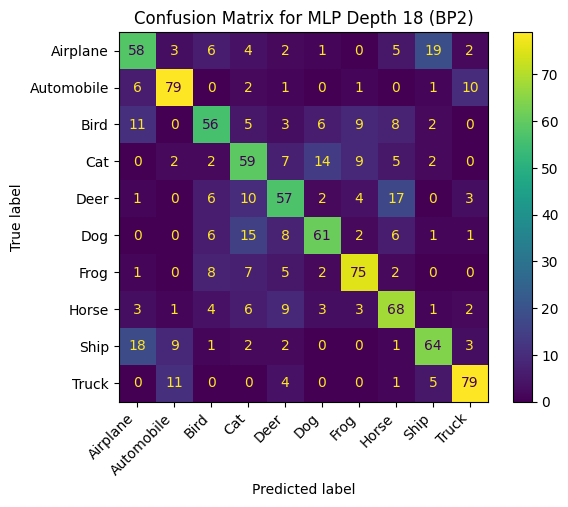


Classification Report for MLP Depth 18 (BP2):
              precision    recall  f1-score   support

    Airplane       0.59      0.58      0.59       100
  Automobile       0.75      0.79      0.77       100
        Bird       0.63      0.56      0.59       100
         Cat       0.54      0.59      0.56       100
        Deer       0.58      0.57      0.58       100
         Dog       0.69      0.61      0.65       100
        Frog       0.73      0.75      0.74       100
       Horse       0.60      0.68      0.64       100
        Ship       0.67      0.64      0.66       100
       Truck       0.79      0.79      0.79       100

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000


-----------------------------------------------------------------------------

Depth 19:
Accuracy: 66.90%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


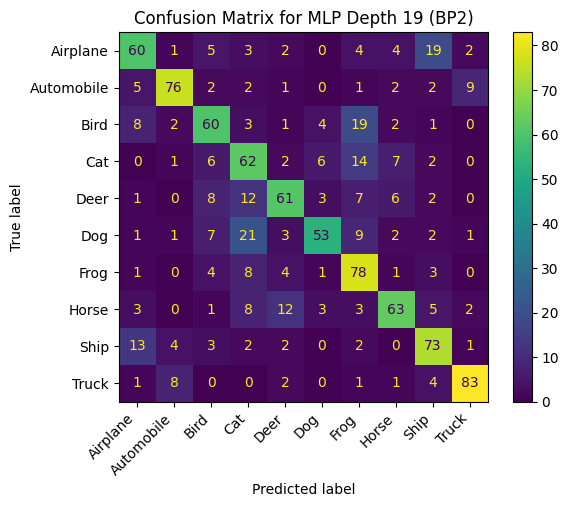


Classification Report for MLP Depth 19 (BP2):
              precision    recall  f1-score   support

    Airplane       0.65      0.60      0.62       100
  Automobile       0.82      0.76      0.79       100
        Bird       0.62      0.60      0.61       100
         Cat       0.51      0.62      0.56       100
        Deer       0.68      0.61      0.64       100
         Dog       0.76      0.53      0.62       100
        Frog       0.57      0.78      0.66       100
       Horse       0.72      0.63      0.67       100
        Ship       0.65      0.73      0.69       100
       Truck       0.85      0.83      0.84       100

    accuracy                           0.67      1000
   macro avg       0.68      0.67      0.67      1000
weighted avg       0.68      0.67      0.67      1000


-----------------------------------------------------------------------------

Depth 20:
Accuracy: 65.80%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


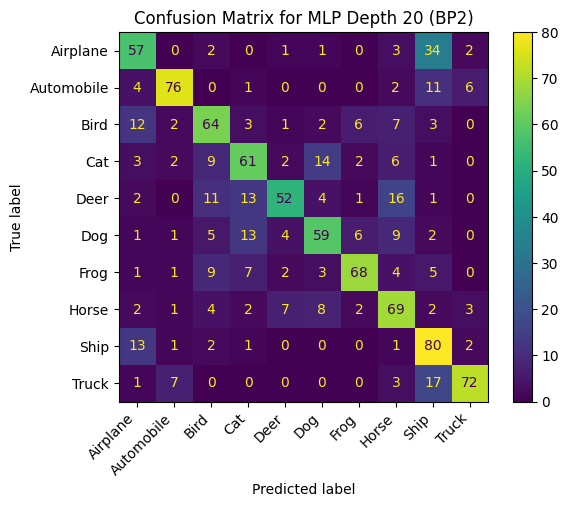


Classification Report for MLP Depth 20 (BP2):
              precision    recall  f1-score   support

    Airplane       0.59      0.57      0.58       100
  Automobile       0.84      0.76      0.80       100
        Bird       0.60      0.64      0.62       100
         Cat       0.60      0.61      0.61       100
        Deer       0.75      0.52      0.62       100
         Dog       0.65      0.59      0.62       100
        Frog       0.80      0.68      0.74       100
       Horse       0.57      0.69      0.63       100
        Ship       0.51      0.80      0.62       100
       Truck       0.85      0.72      0.78       100

    accuracy                           0.66      1000
   macro avg       0.68      0.66      0.66      1000
weighted avg       0.68      0.66      0.66      1000


-----------------------------------------------------------------------------

Evaluating BP3 Models:
Hidden Layer Size 128:
Accuracy: 68.20%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


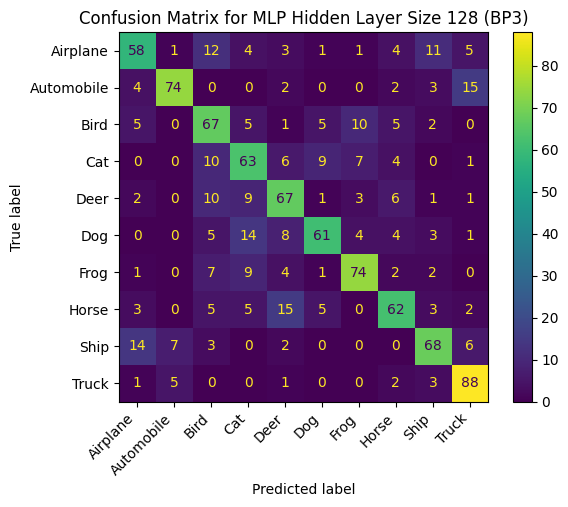


Classification Report for MLP Hidden Layer Size 128 (BP3):
              precision    recall  f1-score   support

    Airplane       0.66      0.58      0.62       100
  Automobile       0.85      0.74      0.79       100
        Bird       0.56      0.67      0.61       100
         Cat       0.58      0.63      0.60       100
        Deer       0.61      0.67      0.64       100
         Dog       0.73      0.61      0.67       100
        Frog       0.75      0.74      0.74       100
       Horse       0.68      0.62      0.65       100
        Ship       0.71      0.68      0.69       100
       Truck       0.74      0.88      0.80       100

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000


-----------------------------------------------------------------------------

Hidden Layer Size 256:
Accuracy: 69.80%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


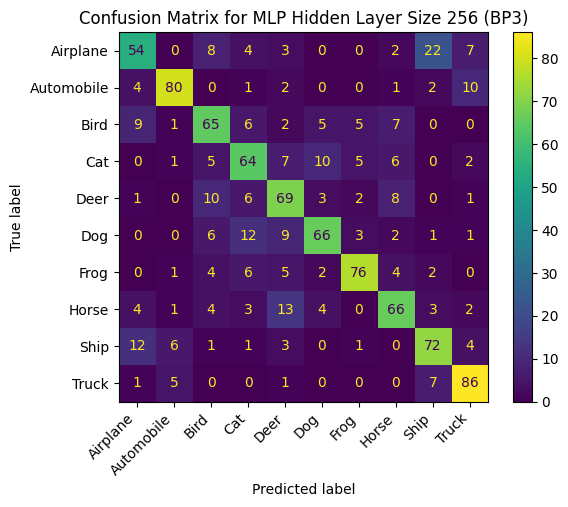


Classification Report for MLP Hidden Layer Size 256 (BP3):
              precision    recall  f1-score   support

    Airplane       0.64      0.54      0.58       100
  Automobile       0.84      0.80      0.82       100
        Bird       0.63      0.65      0.64       100
         Cat       0.62      0.64      0.63       100
        Deer       0.61      0.69      0.64       100
         Dog       0.73      0.66      0.69       100
        Frog       0.83      0.76      0.79       100
       Horse       0.69      0.66      0.67       100
        Ship       0.66      0.72      0.69       100
       Truck       0.76      0.86      0.81       100

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000


-----------------------------------------------------------------------------

Hidden Layer Size 512:
Accuracy: 71.10%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


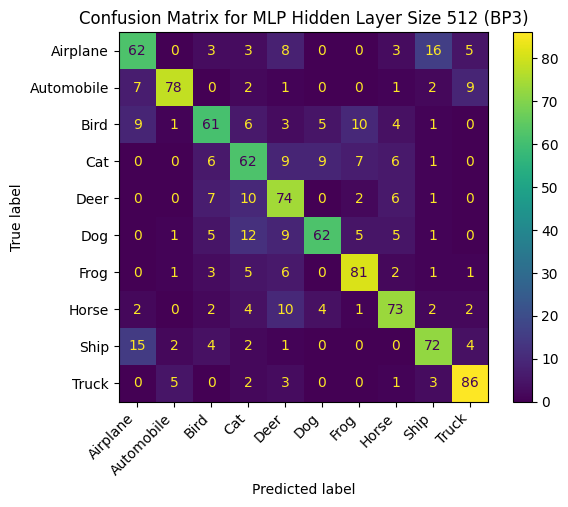


Classification Report for MLP Hidden Layer Size 512 (BP3):
              precision    recall  f1-score   support

    Airplane       0.65      0.62      0.64       100
  Automobile       0.89      0.78      0.83       100
        Bird       0.67      0.61      0.64       100
         Cat       0.57      0.62      0.60       100
        Deer       0.60      0.74      0.66       100
         Dog       0.78      0.62      0.69       100
        Frog       0.76      0.81      0.79       100
       Horse       0.72      0.73      0.73       100
        Ship       0.72      0.72      0.72       100
       Truck       0.80      0.86      0.83       100

    accuracy                           0.71      1000
   macro avg       0.72      0.71      0.71      1000
weighted avg       0.72      0.71      0.71      1000


-----------------------------------------------------------------------------

Hidden Layer Size 1024:
Accuracy: 68.70%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


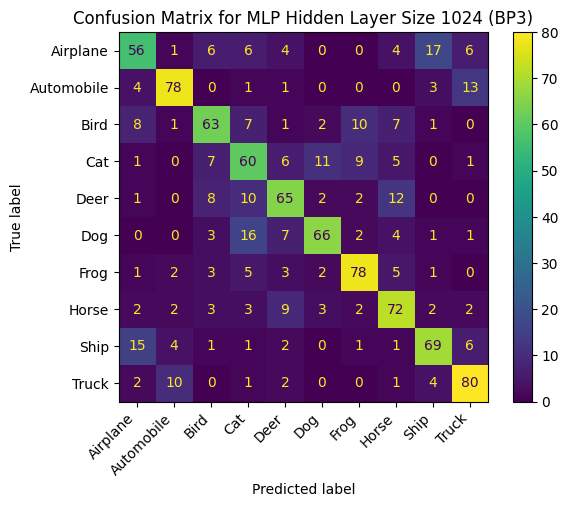


Classification Report for MLP Hidden Layer Size 1024 (BP3):
              precision    recall  f1-score   support

    Airplane       0.62      0.56      0.59       100
  Automobile       0.80      0.78      0.79       100
        Bird       0.67      0.63      0.65       100
         Cat       0.55      0.60      0.57       100
        Deer       0.65      0.65      0.65       100
         Dog       0.77      0.66      0.71       100
        Frog       0.75      0.78      0.76       100
       Horse       0.65      0.72      0.68       100
        Ship       0.70      0.69      0.70       100
       Truck       0.73      0.80      0.77       100

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000


-----------------------------------------------------------------------------

Hidden Layer Size 2048:
Accuracy: 69.60%


<ipython-input-8-ca0a35bab493>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


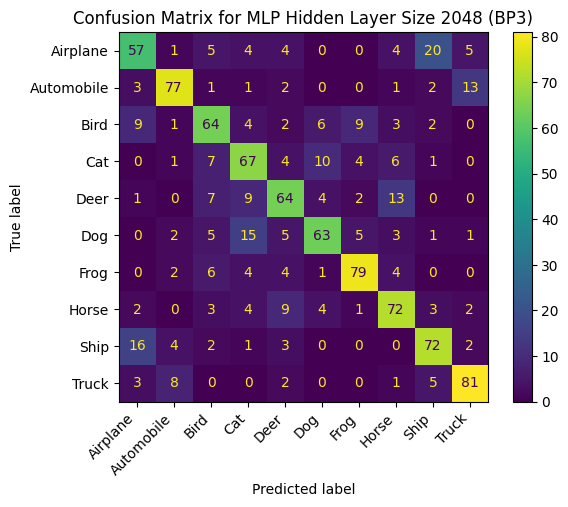


Classification Report for MLP Hidden Layer Size 2048 (BP3):
              precision    recall  f1-score   support

    Airplane       0.63      0.57      0.60       100
  Automobile       0.80      0.77      0.79       100
        Bird       0.64      0.64      0.64       100
         Cat       0.61      0.67      0.64       100
        Deer       0.65      0.64      0.64       100
         Dog       0.72      0.63      0.67       100
        Frog       0.79      0.79      0.79       100
       Horse       0.67      0.72      0.70       100
        Ship       0.68      0.72      0.70       100
       Truck       0.78      0.81      0.79       100

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000


-----------------------------------------------------------------------------

Total Runtime: 792.94 seconds


In [8]:
# Block 15
# 5: Multi-Layer Perceptron
# *BP4 - we created this bp to evaluate all the saved models

# Now we will do the evaluation for all the various models we have created and saved here

# Confusion Matrix and Classficiation for bp1

# Confusion Matrix for all the depth levels in bp2
# Classification Report for all depth levels in bp2

# Confusion Matrix for all the hidden layer size in bp3
# Classification Report for all hidden layer size in bp3


# Humans Wrath


# 5: Multi-Layer Perceptron
## Evaluate Models from BP1, BP2, and BP3

# for BP1

class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()

        self.fc1 = nn.Linear(50, 512)           # 50x512 Input Layer
        self.ReLU1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 512)          # 512x512 Hidden Layer
        self.BatchNorm2 = nn.BatchNorm1d(512)
        self.ReLU2 = nn.ReLU()

        self.fc3 = nn.Linear(512, 10)           # 512x10 Output Layer


    # Forward Pass
    def forward(self, x):
        x = self.ReLU1(self.fc1(x))
        x = self.ReLU2(self.BatchNorm2(self.fc2(x)))
        x = self.fc3(x)
        return x



# For BP2
class MultiLayerPerceptronDepth(nn.Module):
    def __init__(self, depth):
        super(MultiLayerPerceptronDepth, self).__init__()
        layers = []

        # input layer
        layers.append(nn.Linear(50, 512))
        layers.append(nn.ReLU())


        # input n hidden layers based on the depth input
        for _ in range(depth):
            layers.append(nn.Linear(512, 512))
            layers.append(nn.BatchNorm1d(512))
            layers.append(nn.ReLU())

        # output layer
        layers.append(nn.Linear(512, 10))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


# for BP3
class MultiLayerPerceptronHiddenLayerSize(nn.Module):
    def __init__(self, hidden_size):
        super(MultiLayerPerceptronHiddenLayerSize, self).__init__()

        self.fc1 = nn.Linear(50, hidden_size)
        self.ReLU1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.BatchNorm2 = nn.BatchNorm1d(hidden_size)
        self.ReLU2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_size, 10)


    # Forward Pass
    def forward(self, x):
        x = self.ReLU1(self.fc1(x))
        x = self.ReLU2(self.BatchNorm2(self.fc2(x)))
        x = self.fc3(x)
        return x


from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch

# Load PCA features and labels
training_features_PCA = np.load("training_features_reduced_PCA.npy")
training_labels = np.load("training_labels.npy")
test_features_PCA = np.load("test_features_reduced_PCA.npy")
test_labels = np.load("test_labels.npy")

# Resahpe the PCA features to be a 50x512 from a 64x512
training_features_PCA_50x512 = training_features_PCA[:, :50]  # Select first 50 features for training
test_features_PCA_50x512 = test_features_PCA[:, :50]

# Convert to pytorch Tensors
X_train = torch.tensor(training_features_PCA_50x512, dtype=torch.float32)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(test_features_PCA_50x512, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test = X_test.to(device)
y_test = y_test.to(device)

# Function to load a model and evaluate it
def load_and_evaluate_model(model_path, model_class, *model_args):
    # Load the model
    model = model_class(*model_args)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Predict on test data
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)

    # Calculate accuracy
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)

    # Generate confusion matrix and classification report
    cm = confusion_matrix(y_test.cpu(), predicted.cpu())
    cr = classification_report(y_test.cpu(), predicted.cpu(),target_names=class_names)

    return accuracy, cm, cr

# Evaluate BP1 Model
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print("Evaluating BP1 Model:")
accuracy_bp1, cm_bp1, cr_bp1 = load_and_evaluate_model("mlp_model_bp1.pth", MultiLayerPerceptron)
print(f"Accuracy: {accuracy_bp1 * 100:.2f}%")
disp_bp1 = ConfusionMatrixDisplay(confusion_matrix=cm_bp1, display_labels=class_names)
disp_bp1.plot()
plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
plt.title("Confusion Matrix for MLP BP1")
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()
print("\nClassification Report for MLP BP1:")
print(cr_bp1)
print("\n" + "----------------------------------------------------------------------------" + "\n")

# Evaluate BP2 Models with Depths [1, 2, ..., 20]
print("Evaluating BP2 Models:")
for depth in range(1, 21):
    print(f"Depth {depth}:")
    accuracy_bp2, cm_bp2, cr_bp2 = load_and_evaluate_model(
        f"mlp_model_depth_{depth}_bp2.pth", MultiLayerPerceptronDepth, depth
    )
    print(f"Accuracy: {accuracy_bp2 * 100:.2f}%")
    disp_bp2 = ConfusionMatrixDisplay(confusion_matrix=cm_bp2, display_labels=class_names)
    disp_bp2.plot()
    plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
    plt.title(f"Confusion Matrix for MLP Depth {depth} (BP2)")
    plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
    plt.show()
    print(f"\nClassification Report for MLP Depth {depth} (BP2):")
    print(cr_bp2)
    print("\n" + "-----------------------------------------------------------------------------" + "\n")



# Evaluate BP3 saved Models with Hidden Layer Sizes [128, 256, 512, 1024, 2048]
print("Evaluating BP3 Models:")
hidden_layer_sizes = [128, 256, 512, 1024, 2048]
for hidden_size in hidden_layer_sizes:
    print(f"Hidden Layer Size {hidden_size}:")
    accuracy_bp3, cm_bp3, cr_bp3 = load_and_evaluate_model(
        f"mlp_hidden_layer_size_{hidden_size}_bp3.pth", MultiLayerPerceptronHiddenLayerSize, hidden_size
    )
    print(f"Accuracy: {accuracy_bp3 * 100:.2f}%")
    disp_bp3 = ConfusionMatrixDisplay(confusion_matrix=cm_bp3, display_labels=class_names)
    disp_bp3.plot()
    plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
    plt.title(f"Confusion Matrix for MLP Hidden Layer Size {hidden_size} (BP3)")
    plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
    plt.show()
    print(f"\nClassification Report for MLP Hidden Layer Size {hidden_size} (BP3):")
    print(cr_bp3)
    print("\n" + "-----------------------------------------------------------------------------" + "\n")

end_time = time.time()
print(f"Total Runtime: {end_time - start_time:.2f} seconds")


<body>
    <h1>6 - Convolutional Neural Network</h1>
    <p>
        1. Implement and train a VGG11 net on the training set of CIFAR-10. Use the training images directly for this part.
        VGG11 was an earlier version of VGG16 and can be found as model A in Table 1 of this
        <a href="https://arxiv.org/pdf/1409.1556.pdf">paper</a>, whose Section 2.1 also gives you all the details about each layer.
    </p>
    <p>
        For your convenience, we list the details of the VGG11 architecture here. The convolutional layers are denoted as
        <strong>Conv(number of input channels, number of output channels, kernel size, stride, padding)</strong>;
        the batch normalization layers are denoted as <strong>BatchNorm(number of channels)</strong>;
        the max-pooling layers are denoted as <strong>MaxPool(kernel size, stride)</strong>;
        the fully-connected layers are denoted as <strong>Linear(number of input features, number of output features)</strong>;
        the dropout layers are denoted as <strong>Dropout(dropout ratio)</strong>:
    </p>
    <ul>
        <li>Conv(001, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)</li>
        <li>Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)</li>
        <li>Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU</li>
        <li>Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)</li>
        <li>Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU</li>
        <li>Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)</li>
        <li>Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU</li>
        <li>Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)</li>
        <li>Linear(0512, 4096) - ReLU - Dropout(0.5)</li>
        <li>Linear(4096, 4096) - ReLU - Dropout(0.5)</li>
        <li>Linear(4096, 10)</li>
    </ul>
    <p>
        You should use the following in your training process unless specified otherwise:
        <strong>cross-entropy loss torch.nn.CrossEntropyLoss</strong>, and optimize using SGD optimizer with <strong>momentum=0.9</strong>.
    </p>


In [ ]:
# Block 16
# 6: Convolution Neural Network
## Bullet Point 1

# We will build a Convolutional Neural Network based on the VGG11 archtectural model

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
import time

start_time = time.time()

class CNN_VGG11_BP1(nn.Module):
    def __init__(self):
        super(CNN_VGG11_BP1, self).__init__()
        self.features = nn.Sequential(

            # Conv1 layer
            nn.Conv2d(3, 64, kernel_size=3,stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv3 layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),


            # Conv4 layer
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv5 layer
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),


            # Conv6 layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv7 layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # Conv8 layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )


    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # We need to flatten so the layers can be fully connected
        x = self.classifier(x)
        return x


# Prepare the Cifar-10 dataset again
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# intiialzie the model, the loss function (CCE) and the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_VGG11_BP1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Training Phase
for epoch in range(25): # 25 epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")


# Save the CNN model of BP1 cnn_bgg11_bp1.pth
cnn_model_path = "cnn_vgg11_bp1.pth"
torch.save(model, cnn_model_path)
print(f"Trained CNN model saved at {cnn_model_path}")


# Testing/Validation Phase
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


# Print Accuracy and Runtime

print(f"Accuracy: {100 * correct / total}%")
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds") # 162.79 seconds at 10 epochs | 568.72 sec at 25 epochs | 64 batch size


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.2911014088889217
Epoch 2, Loss: 0.8400436675990633
Epoch 3, Loss: 0.6460777497886087
Epoch 4, Loss: 0.5254057209052698
Epoch 5, Loss: 0.43044577828606073
Epoch 6, Loss: 0.3443289566261079
Epoch 7, Loss: 0.2756013729731026
Epoch 8, Loss: 0.2221681989319718
Epoch 9, Loss: 0.1810371650697287
Epoch 10, Loss: 0.14009000053700735
Epoch 11, Loss: 0.107903603854401
Epoch 12, Loss: 0.09340211484953999
Epoch 13, Loss: 0.08221132263167263
Epoch 14, Loss: 0.07364688825655415
Epoch 15, Loss: 0.05385708404229144
Epoch 16, Loss: 0.05853558353492585
Epoch 17, Loss: 0.04554210477338894
Epoch 18, Loss: 0.04051598835082384
Epoch 19, Loss: 0.028201542177578556
Epoch 20, Loss: 0.030950614006307376
Epoch 21, Loss: 0.02647989028400727
Epoch 22, Loss: 0.030173090966752594
Epoch 23, Loss: 0.021569568753784785
Epoch 24, Loss: 0.02437877574274076
Epoch 25, Loss: 0.021426330968623012
Trained CNN model saved at cnn_vgg11_b

<p>2. Experiment by adding or removing convolutional layers in your architecture. Observe and document how
the depth of the network influences the model’s ability to learn and generalize from the data.</p>

In [ ]:
# Block 17
# 6: Convolution Neural Network
## Bullet Point 2

# I chose the option of removing the Conv layers, ill begin by removing a few Conv layers and observe how that changes the accuracy
# I will reuse the same code for the question above but will only remove the layers Conv6 Conv7 and Conv8
# This also resulted in modifying Conv5 so that the dimensions of it woudl match the dimensions of the Linear Layer

# We will build a Convolutional Neural Network based on the VGG11 archtectural model

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

start_time = time.time()

class CNN_VGG11_BP2(nn.Module):
    def __init__(self):
        super(CNN_VGG11_BP2, self).__init__()
        self.features = nn.Sequential(

            # Conv1 layer
            nn.Conv2d(3, 64, kernel_size=3,stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv3 layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),


            # Conv4 layer
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv5 layer
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # We had to make the kernal 4x4 for that it woudl match the linear dimensions of 512
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096), # THis had to be udpaetd to match the dimnesions after Conv6 instesad of Conv8 (manually calcualted)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )


    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # We need to flatten so the layers can be fully connected
        x = self.classifier(x)
        return x


# Prepare the Cifar-10 dataset again

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# intiialzie the model, the loss function (CCE) and the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_VGG11_BP2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Training Phase
for epoch in range(25): # 25 epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")


# Save the entire reduced CNN model with archtitecrue and weights as "cnn_cgg11_bp2.pth"
cnn_reduced_model_path = "cnn_vgg11_reduced_bp2.pth"
torch.save(model, cnn_reduced_model_path)
print(f"Trained CNN reduced model saved at {cnn_reduced_model_path}")


# Testing/Validation Phase
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


# Print Accuracy and Runtime

print(f"Accuracy: {100 * correct / total}%")
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds") # 153 sec at 10 epochs |  abt 502.92 sec at 25 epochs |


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.325139914479707
Epoch 2, Loss: 0.9013732519296124
Epoch 3, Loss: 0.7272511318592769
Epoch 4, Loss: 0.5998735807054792
Epoch 5, Loss: 0.5136587714866909
Epoch 6, Loss: 0.42725690852498155
Epoch 7, Loss: 0.360738039645545
Epoch 8, Loss: 0.30070696439584504
Epoch 9, Loss: 0.250261049922508
Epoch 10, Loss: 0.2159729747749541
Epoch 11, Loss: 0.17067494226829208
Epoch 12, Loss: 0.1511626110895706
Epoch 13, Loss: 0.12470343973166953
Epoch 14, Loss: 0.10677622384665643
Epoch 15, Loss: 0.08905779293236916
Epoch 16, Loss: 0.08072395914691545
Epoch 17, Loss: 0.06727233341319071
Epoch 18, Loss: 0.061950647297775004
Epoch 19, Loss: 0.060647162600167934
Epoch 20, Loss: 0.04890854761209589
Epoch 21, Loss: 0.041000113912771426
Epoch 22, Loss: 0.03686572427795444
Epoch 23, Loss: 0.028014524151570575
Epoch 24, Loss: 0.031614875975989595
Epoch 25, Loss: 0.035657746837368484
Trained CNN reduced model saved at cnn_

<p> 3. Adjust the kernel sizes used in your convolutional layers. Experiment with larger kernels (e.g., 5 × 5 or 7
× 7) as well as smaller ones (e.g., 2 × 2 or 3 × 3). Analyze the trade-offs in terms of spatial granularity
versus computational cost and how different kernel sizes influence the recognition of broader features
versus finer details.</p>

In [ ]:
# Block 18
# 6: Convolution Neural Network
## Bullet Point 3 - Part 1 Big Kernels (7x7)

# We will reuse the same code as bullet point 1 but we will use atleast 2 7x7 kernels and adjust the dimenisosn of the rest accordingly
# Firstly We will increase the kernel size to a 7x7 for covn1 conv2 but doing this we have to adjust the dimenisons os that it will match for a calcaualtion.
# In result we had to remove the rest of the Conv layers and adjust the linear layer so that the dimenisosn woudl match when performing th emultiplciations with each other


from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

start_time = time.time()

class CNN_VGG11_BP3_BigKernels(nn.Module):
    def __init__(self):
        super(CNN_VGG11_BP3_BigKernels, self).__init__()
        self.features = nn.Sequential(

            # Conv1 layer
            nn.Conv2d(3, 64, kernel_size=7,stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 layer
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )


    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # We need to flatten so the layers can be fully connected
        x = self.classifier(x)
        return x


# Prepare the Cifar-10 dataset again

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# intiialzie the model, the loss function (CCE) and the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_VGG11_BP3_BigKernels().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Training Phase
for epoch in range(25): # 25 epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")


# Save the entire CNN model with big kernels as cnn_big_kernels_bp3.pth
cnn_big_kernels_path = "cnn_big_kernels_bp3.pth"
torch.save(model, cnn_big_kernels_path)
print(f"Trained CNN model with big kernels (7x7) saved at {cnn_big_kernels_path}")




# Testing/Validation Phase
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


# Print Accuracy and Runtime

print(f"Accuracy: {100 * correct / total}%")
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds") # 150 seconds for 10 epochs | 500 seconds at 25 epochs 79.19%



Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.4620340258416618
Epoch 2, Loss: 1.0995243828924721
Epoch 3, Loss: 0.9230466307429097
Epoch 4, Loss: 0.79196820078451
Epoch 5, Loss: 0.6928760666981377
Epoch 6, Loss: 0.602134434129957
Epoch 7, Loss: 0.5221573077428067
Epoch 8, Loss: 0.44962452672174213
Epoch 9, Loss: 0.38305791532215866
Epoch 10, Loss: 0.3192867983485122
Epoch 11, Loss: 0.2640347812048462
Epoch 12, Loss: 0.22335279625280738
Epoch 13, Loss: 0.18523193468980473
Epoch 14, Loss: 0.14920084751294474
Epoch 15, Loss: 0.13106235981587788
Epoch 16, Loss: 0.10980739133180026
Epoch 17, Loss: 0.09743326470551207
Epoch 18, Loss: 0.08507544933663458
Epoch 19, Loss: 0.07444221152187995
Epoch 20, Loss: 0.06772407821601119
Epoch 21, Loss: 0.06248712704738464
Epoch 22, Loss: 0.04764955647258788
Epoch 23, Loss: 0.049092066640694106
Epoch 24, Loss: 0.04537779778745883
Epoch 25, Loss: 0.04539296451716057
Trained CNN model with big kernels (7x7) sav

In [ ]:
# Block 19
# TODO
# 6: Convolution Neural Network
## Bullet Point 3 - Part 2 Small Kernels (2x2)

# To be fair the CNN architecture is already that of a small kernel as they all consist of 3x3 kernels
# So for this section we will just use 2x2 kernels to adapt to the question

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
import time

start_time = time.time()

# CNN with Small Kernels (2x2)
class CNN_VGG11_BP3_SmallKernels(nn.Module):
    def __init__(self):
        super(CNN_VGG11_BP3_SmallKernels, self).__init__()
        self.features = nn.Sequential(
            # Conv1 layer (kernel size 2x2)
            nn.Conv2d(3, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 layer (kernel size 2x2)
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv3 layer (kernel size 2x2)
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv4 layer (kernel size 2x2)
            nn.Conv2d(256, 512, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  # Adjust dimensions based on small kernels
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),  # CIFAR-10 has 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layers
        x = self.classifier(x)
        return x


# Prepare the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_VGG11_BP3_SmallKernels().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training Phase
for epoch in range(25): # 25 epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# Save the CNN model with small kernels
cnn_small_kernels_path = "cnn_small_kernels_bp3.pth"  # Path to save the model
torch.save(model, cnn_small_kernels_path)
print(f"Trained CNN model with small kernels (2x2) saved at {cnn_small_kernels_path}")

# Testing/Validation Phase
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


# Print Accuracy and Runtime
print(f"Accuracy: {100 * correct / total}%")
end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds") # 515 seconds at 79% accuracy





Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.3306257640156904
Epoch 2, Loss: 0.9082258477082947
Epoch 3, Loss: 0.7254800203892277
Epoch 4, Loss: 0.5980772507922424
Epoch 5, Loss: 0.49858231152719856
Epoch 6, Loss: 0.41483792682628495
Epoch 7, Loss: 0.33560603765575475
Epoch 8, Loss: 0.2816837957829161
Epoch 9, Loss: 0.22132561703110137
Epoch 10, Loss: 0.18751772498364186
Epoch 11, Loss: 0.15188195270455213
Epoch 12, Loss: 0.12323922277880771
Epoch 13, Loss: 0.10920565190089061
Epoch 14, Loss: 0.08900812719388844
Epoch 15, Loss: 0.07572974265395852
Epoch 16, Loss: 0.06792501228697159
Epoch 17, Loss: 0.05895994436365012
Epoch 18, Loss: 0.0506037188477426
Epoch 19, Loss: 0.04275002902986415
Epoch 20, Loss: 0.04219943503468104
Epoch 21, Loss: 0.03502286561941037
Epoch 22, Loss: 0.031715834706947575
Epoch 23, Loss: 0.035738459284714474
Epoch 24, Loss: 0.026358177245724375
Epoch 25, Loss: 0.02567715267598679
Trained CNN model with small kernels

Files already downloaded and verified
Evaluating CNN_BP1...


<ipython-input-9-77875c7e687d>:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)



Classification Report for CNN_BP1:
              precision    recall  f1-score   support

    airplane       0.85      0.85      0.85      1000
  automobile       0.95      0.90      0.92      1000
        bird       0.81      0.74      0.77      1000
         cat       0.68      0.68      0.68      1000
        deer       0.82      0.83      0.83      1000
         dog       0.69      0.79      0.73      1000
        frog       0.88      0.88      0.88      1000
       horse       0.90      0.85      0.88      1000
        ship       0.88      0.92      0.90      1000
       truck       0.91      0.89      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



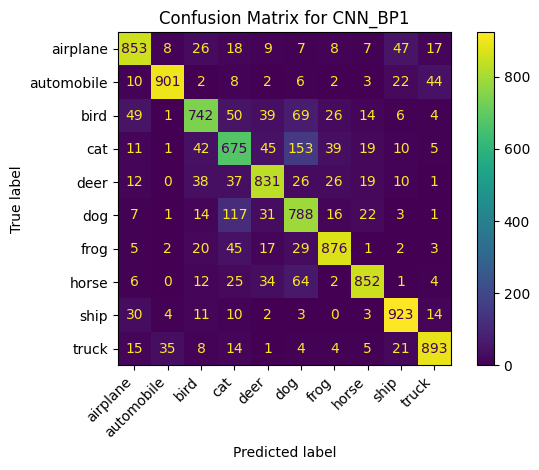


-----------------------------------------------------------------------
Evaluating CNN_BP2...


<ipython-input-9-77875c7e687d>:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)



Classification Report for CNN_BP2:
              precision    recall  f1-score   support

    airplane       0.89      0.83      0.86      1000
  automobile       0.91      0.94      0.92      1000
        bird       0.79      0.76      0.77      1000
         cat       0.58      0.81      0.68      1000
        deer       0.83      0.82      0.83      1000
         dog       0.75      0.77      0.76      1000
        frog       0.95      0.80      0.87      1000
       horse       0.94      0.83      0.88      1000
        ship       0.91      0.91      0.91      1000
       truck       0.92      0.89      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.85      0.83      0.84     10000
weighted avg       0.85      0.83      0.84     10000



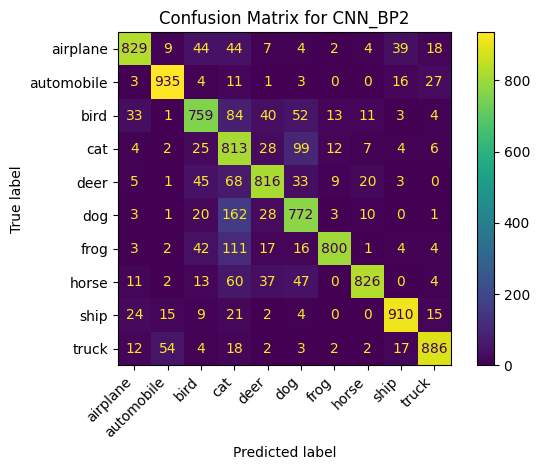


-----------------------------------------------------------------------
Evaluating CNN_BP3_BigKernels...


<ipython-input-9-77875c7e687d>:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)



Classification Report for CNN_BP3_BigKernels:
              precision    recall  f1-score   support

    airplane       0.82      0.83      0.82      1000
  automobile       0.87      0.90      0.89      1000
        bird       0.75      0.72      0.74      1000
         cat       0.64      0.61      0.63      1000
        deer       0.78      0.76      0.77      1000
         dog       0.66      0.76      0.70      1000
        frog       0.85      0.85      0.85      1000
       horse       0.84      0.85      0.84      1000
        ship       0.90      0.85      0.87      1000
       truck       0.88      0.84      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



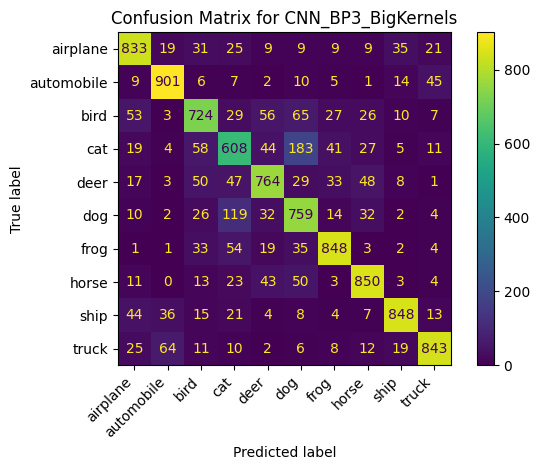


-----------------------------------------------------------------------
Evaluating CNN_BP3_SmallKernels...


<ipython-input-9-77875c7e687d>:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)



Classification Report for CNN_BP3_SmallKernels:
              precision    recall  f1-score   support

    airplane       0.84      0.84      0.84      1000
  automobile       0.85      0.93      0.89      1000
        bird       0.78      0.70      0.74      1000
         cat       0.65      0.61      0.63      1000
        deer       0.80      0.76      0.78      1000
         dog       0.61      0.81      0.70      1000
        frog       0.89      0.81      0.85      1000
       horse       0.85      0.85      0.85      1000
        ship       0.92      0.87      0.90      1000
       truck       0.89      0.85      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



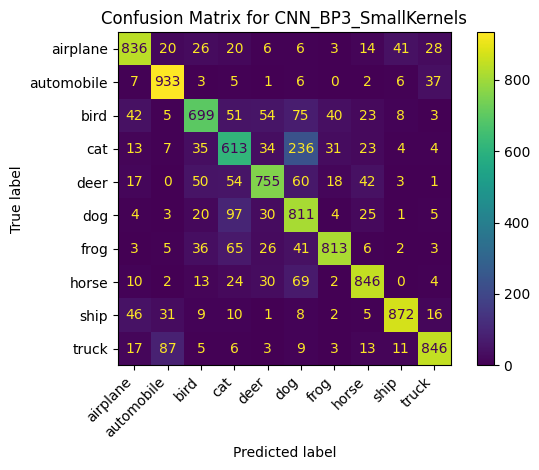


-----------------------------------------------------------------------


In [9]:
# Block 20
# 6: Convolution Neural Network
## Bullet Point 4: Evaluate All Saved Models


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

# Prepare the CIFAR-10 dataset for testing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Redefining the Classes for each, Bp1, Bp2, Bp3 Big Kernel, Bp3 Small Kernel


# BP 1

class CNN_VGG11_BP1(nn.Module):
    def __init__(self):
        super(CNN_VGG11_BP1, self).__init__()
        self.features = nn.Sequential(

            # Conv1 layer
            nn.Conv2d(3, 64, kernel_size=3,stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv3 layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),


            # Conv4 layer
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv5 layer
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),


            # Conv6 layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv7 layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # Conv8 layer
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )


    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # We need to flatten so the layers can be fully connected
        x = self.classifier(x)
        return x



# BP 2

class CNN_VGG11_BP2(nn.Module):
    def __init__(self):
        super(CNN_VGG11_BP2, self).__init__()
        self.features = nn.Sequential(

            # Conv1 layer
            nn.Conv2d(3, 64, kernel_size=3,stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv3 layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),


            # Conv4 layer
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv5 layer
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # We had to make the kernal 4x4 for that it woudl match the linear dimensions of 512
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096), # THis had to be udpaetd to match the dimnesions after Conv6 instesad of Conv8 (manually calcualted)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )


    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # We need to flatten so the layers can be fully connected
        x = self.classifier(x)
        return x



# BP 3 - Big Kernel

class CNN_VGG11_BP3_BigKernels(nn.Module):
    def __init__(self):
        super(CNN_VGG11_BP3_BigKernels, self).__init__()
        self.features = nn.Sequential(

            # Conv1 layer
            nn.Conv2d(3, 64, kernel_size=7,stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 layer
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )


    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # We need to flatten so the layers can be fully connected
        x = self.classifier(x)
        return x


# BP 4 - Small Kernel

class CNN_VGG11_BP3_SmallKernels(nn.Module):
    def __init__(self):
        super(CNN_VGG11_BP3_SmallKernels, self).__init__()
        self.features = nn.Sequential(
            # Conv1 layer (kernel size 2x2)
            nn.Conv2d(3, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 layer (kernel size 2x2)
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv3 layer (kernel size 2x2)
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv4 layer (kernel size 2x2)
            nn.Conv2d(256, 512, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  # Adjust dimensions based on small kernels
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),  # CIFAR-10 has 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layers
        x = self.classifier(x)
        return x




# Model paths for evaluation
model_paths = {
    "CNN_BP1": "cnn_vgg11_bp1.pth",
    "CNN_BP2": "cnn_vgg11_reduced_bp2.pth",
    "CNN_BP3_BigKernels": "cnn_big_kernels_bp3.pth",
    "CNN_BP3_SmallKernels": "cnn_small_kernels_bp3.pth"
}

# Evaluate each model
for model_name, model_path in model_paths.items():
    print(f"Evaluating {model_name}...")

    # Load the saved model
    model = torch.load(model_path)
    model.to(device)
    model.eval()

    # Initialize true and predicted labels
    y_true = []
    y_pred = []

    # Testing/Validation Phase
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Generate Classification Report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

    # Generate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
    disp.plot()
    plt.xticks(rotation=45, ha='right')  # Rotate x labels 45 degrees
    plt.title(f"Confusion Matrix for {model_name}")
    plt.tight_layout()  # Adjust the layout to fit everything nicely
    plt.show()
    print("\n-----------------------------------------------------------------------")

